In [1]:
## Otimizando o abastecimento de produtos no varejo com Random Forest
# GUILHERME LIMA DSA 231

##########################################################################

### MATRIZ PRINCIPAL QUE SERÁ UTILIZADA PARA TREINAR O MODELO

##########################################################################


##CARREGANDO AS BIBLIOTECAS 
import numpy as np
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split


semente = 45
np.random.seed(semente)


##CONFIGURANDO NUMEROS COM 2 CASAS DECIMAIS
pd.set_option('Float_format','{:.2f}'.format)

##CRIANDO DF E A BASE COM NUMEROS ALEATÓRIOS minimo 1 máximo 171 em 35mil linhas
a = np.random.randint(1, 171, size=35000)
base_zero = pd.DataFrame(a)


########## LISTA DE PRODUTOS
b = [
'iPhone 14',
'iPhone 13',
'iPhone 14 Pro',
'iPhone 13 Pro',
'iPhone SE',
'Samsung Galaxy S22',
'Samsung Galaxy S23',
'Samsung Galaxy S24',
'Samsung Galaxy A53',
'Samsung Galaxy A73',
'Moto G200',
'Moto Edge X30',
'Moto E22',
'Moto G84',
'Moto E40',
'MacBook Pro',
'iPad Air',
'AirPods Pro',
'Apple Watch Series 8',
'Mac Mini',
'Samsung Galaxy Tab S8',
'Samsung Neo QLED TV',
'Samsung Galaxy Buds Pro',
'Amazon Echo Show 15',
'Amazon Kindle Scribe',
'Amazon Echo Dot 5ª geração',
'Amazon Halo View']
##ALEATÓRIO PEGA OS PRODUTOS DA LISTA E INSERE NA BASE PELO TAMANHO DA EXTENSÃO
produtos = np.random.choice(b, size=len(base_zero))
##CRIA A COLUNA COM AS INFOS
base_zero['PRODUTOS'] = produtos


########## LISTA DE LOJAS
llpp = [
'Shopping Iguatemi-SP',
'Shopping Morumbi-SP',
'Shopping Eldorado-SP',
'Shopping Cidade Jardim-SP',
'Shopping Pátio Paulista-SP',
'BarraShopping-RJ',
'VillageMall-RJ',
'Shopping Leblon-RJ',
'RioSul Shopping Center-RJ',
'Shopping Metropolitano Barra-RJ',
'BH Shopping-MG',
'DiamondMall-MG',
'Pátio Savassi-MG',
'Shopping Recife-PE',
'RioMar Recife-PE',
'Shopping Barra-BA',
'Salvador Shopping-BA',
'Shopping Center Norte-SP',
'ParkShopping-DF',
'Iguatemi Porto Alegre-RS']
lojas = np.random.choice(llpp, size=len(base_zero))
base_zero['LOJAS'] = lojas


########## DEFININDO A QUANTIDADE DE VENDAS ALEATÓRIO PARA COLUNA, MÁXIMO 240
base_zero = base_zero.rename(columns={0: 'QTD_VENDAS'})
base_zero['QTD_VENDAS'] = base_zero['QTD_VENDAS'].astype(int)
base_zero['QTD_VENDAS'] = np.random.randint(0, 270, size=len(base_zero))


########## DEFININDO A QUANTIDADE DE ESTOQUE ALEATÓRIO PARA COLUNA, MÁXIMO 30
ESTOQUE_LLPP = np.random.randint(1, 127, size=len(base_zero))
base_zero['QTD_ESTOQUE_LLPP'] = ESTOQUE_LLPP
ESTOQUE_CD = np.random.randint(0, 200, size=len(base_zero))
base_zero['QTD_ESTOQUE_CD'] = ESTOQUE_CD
MINIMO_ESTOQUE = np.random.randint(0, 10, size=len(base_zero))
base_zero['ESTOQUE_MINIMO_LLPP'] = MINIMO_ESTOQUE
base_zero['QTD_ESTOQUE_LLPP'] = base_zero['QTD_ESTOQUE_LLPP'].astype(int)
base_zero['QTD_ESTOQUE_CD'] = base_zero['QTD_ESTOQUE_CD'].astype(int)
base_zero['ESTOQUE_MINIMO_LLPP'] = base_zero['ESTOQUE_MINIMO_LLPP'].astype(int)


########## DEFININDO O SLA DE CADA FORNECEDOR
SLA = np.random.randint(1, 15, size=len(base_zero))
base_zero['SLA_RECEBIMENTO_FORNEC'] = SLA
base_zero['SLA_RECEBIMENTO_FORNEC'] = base_zero['SLA_RECEBIMENTO_FORNEC'].astype(int)


########## DEFININDO OS MESES
MES = np.random.randint(1, 12, size=len(base_zero))
base_zero['MES'] = MES

########## DEFININDO OS ANOS
ANO = np.random.randint(18, 24, size=len(base_zero))
ANO = 2000+ANO
base_zero['ANO'] = ANO


########## CRIANDO COLUNA DE CATEGORIA, SMARTS
base_zero.loc[base_zero['PRODUTOS'] == 'iPhone 14', 'CATEGORIA'] = 'SMARTPHONE'
base_zero.loc[base_zero['PRODUTOS'] == 'iPhone 13', 'CATEGORIA'] = 'SMARTPHONE'
base_zero.loc[base_zero['PRODUTOS'] == 'iPhone 14 Pro', 'CATEGORIA'] = 'SMARTPHONE'
base_zero.loc[base_zero['PRODUTOS'] == 'iPhone 13 Pro', 'CATEGORIA'] = 'SMARTPHONE'
base_zero.loc[base_zero['PRODUTOS'] == 'iPhone SE', 'CATEGORIA'] = 'SMARTPHONE'
base_zero.loc[base_zero['PRODUTOS'] == 'Samsung Galaxy S22', 'CATEGORIA'] = 'SMARTPHONE'
base_zero.loc[base_zero['PRODUTOS'] == 'Samsung Galaxy S23', 'CATEGORIA'] = 'SMARTPHONE'
base_zero.loc[base_zero['PRODUTOS'] == 'Samsung Galaxy S24', 'CATEGORIA'] = 'SMARTPHONE'
base_zero.loc[base_zero['PRODUTOS'] == 'Samsung Galaxy A53', 'CATEGORIA'] = 'SMARTPHONE'
base_zero.loc[base_zero['PRODUTOS'] == 'Samsung Galaxy A73', 'CATEGORIA'] = 'SMARTPHONE'
base_zero.loc[base_zero['PRODUTOS'] == 'Moto G200', 'CATEGORIA'] = 'SMARTPHONE'
base_zero.loc[base_zero['PRODUTOS'] == 'Moto Edge X30', 'CATEGORIA'] = 'SMARTPHONE'
base_zero.loc[base_zero['PRODUTOS'] == 'Moto E22', 'CATEGORIA'] = 'SMARTPHONE'
base_zero.loc[base_zero['PRODUTOS'] == 'Moto G84', 'CATEGORIA'] = 'SMARTPHONE'
base_zero.loc[base_zero['PRODUTOS'] == 'Moto E40', 'CATEGORIA'] = 'SMARTPHONE'

########## CRIANDO COLUNA DE CATEGORIA, ELETRONICOS
base_zero['CATEGORIA'].fillna('ELETRONICOS', inplace=True)

############ CRIANDO COLUNA DE UF DAS LOJAS
base_zero.loc[base_zero['LOJAS'] == 'Shopping Iguatemi-SP', 'UF'] = 'SP'
base_zero.loc[base_zero['LOJAS'] == 'Shopping Morumbi-SP', 'UF'] = 'SP'
base_zero.loc[base_zero['LOJAS'] == 'Shopping Eldorado-SP', 'UF'] = 'SP'
base_zero.loc[base_zero['LOJAS'] == 'Shopping Cidade Jardim-SP', 'UF'] = 'SP'
base_zero.loc[base_zero['LOJAS'] == 'Shopping Pátio Paulista-SP', 'UF'] = 'SP'
base_zero.loc[base_zero['LOJAS'] == 'BarraShopping-RJ', 'UF'] = 'RJ'
base_zero.loc[base_zero['LOJAS'] == 'VillageMall-RJ', 'UF'] = 'RJ'
base_zero.loc[base_zero['LOJAS'] == 'Shopping Leblon-RJ', 'UF'] = 'RJ'
base_zero.loc[base_zero['LOJAS'] == 'RioSul Shopping Center-RJ', 'UF'] = 'RJ'
base_zero.loc[base_zero['LOJAS'] == 'Shopping Metropolitano Barra-RJ', 'UF'] = 'RJ'
base_zero.loc[base_zero['LOJAS'] == 'BH Shopping-MG', 'UF'] = 'MG'
base_zero.loc[base_zero['LOJAS'] == 'DiamondMall-MG', 'UF'] = 'MG'
base_zero.loc[base_zero['LOJAS'] == 'Pátio Savassi-MG', 'UF'] = 'MG'
base_zero.loc[base_zero['LOJAS'] == 'Shopping Recife-PE', 'UF'] = 'PE'
base_zero.loc[base_zero['LOJAS'] == 'RioMar Recife-PE', 'UF'] = 'PE'
base_zero.loc[base_zero['LOJAS'] == 'Shopping Barra-BA', 'UF'] = 'BA'
base_zero.loc[base_zero['LOJAS'] == 'Salvador Shopping-BA', 'UF'] = 'BA'
base_zero.loc[base_zero['LOJAS'] == 'Shopping Center Norte-SP', 'UF'] = 'SP'
base_zero.loc[base_zero['LOJAS'] == 'ParkShopping-DF', 'UF'] = 'DF'
base_zero.loc[base_zero['LOJAS'] == 'Iguatemi Porto Alegre-RS', 'UF'] = 'RS'


########## CRIANDO COLUNA DE CÓDIGO DAS LOJAS
base_zero.loc[base_zero['LOJAS'] == 'Shopping Iguatemi-SP', 'CENTRO'] = 124
base_zero.loc[base_zero['LOJAS'] == 'Shopping Morumbi-SP', 'CENTRO'] = 110
base_zero.loc[base_zero['LOJAS'] == 'Shopping Eldorado-SP', 'CENTRO'] = 118
base_zero.loc[base_zero['LOJAS'] == 'Shopping Cidade Jardim-SP', 'CENTRO'] = 117
base_zero.loc[base_zero['LOJAS'] == 'Shopping Pátio Paulista-SP', 'CENTRO'] = 122
base_zero.loc[base_zero['LOJAS'] == 'BarraShopping-RJ', 'CENTRO'] = 127
base_zero.loc[base_zero['LOJAS'] == 'VillageMall-RJ', 'CENTRO'] = 134
base_zero.loc[base_zero['LOJAS'] == 'Shopping Leblon-RJ', 'CENTRO'] = 142
base_zero.loc[base_zero['LOJAS'] == 'RioSul Shopping Center-RJ', 'CENTRO'] = 150
base_zero.loc[base_zero['LOJAS'] == 'Shopping Metropolitano Barra-RJ', 'CENTRO'] = 115
base_zero.loc[base_zero['LOJAS'] == 'BH Shopping-MG', 'CENTRO'] = 135
base_zero.loc[base_zero['LOJAS'] == 'DiamondMall-MG', 'CENTRO'] = 147
base_zero.loc[base_zero['LOJAS'] == 'Pátio Savassi-MG', 'CENTRO'] = 163
base_zero.loc[base_zero['LOJAS'] == 'Shopping Recife-PE', 'CENTRO'] = 178
base_zero.loc[base_zero['LOJAS'] == 'RioMar Recife-PE', 'CENTRO'] = 188
base_zero.loc[base_zero['LOJAS'] == 'Shopping Barra-BA', 'CENTRO'] = 195
base_zero.loc[base_zero['LOJAS'] == 'Salvador Shopping-BA', 'CENTRO'] = 200
base_zero.loc[base_zero['LOJAS'] == 'Shopping Center Norte-SP', 'CENTRO'] = 144
base_zero.loc[base_zero['LOJAS'] == 'ParkShopping-DF', 'CENTRO'] = 131
base_zero.loc[base_zero['LOJAS'] == 'Iguatemi Porto Alegre-RS', 'CENTRO'] = 155
base_zero['CENTRO'] = base_zero['CENTRO'].astype(str)


########## CRIANDO COLUNA DE CÓDIGO PARA OS PRODUTOS (SKU)
base_zero.loc[base_zero['PRODUTOS'] == 'iPhone 14', 'SKU'] = 9461
base_zero.loc[base_zero['PRODUTOS'] == 'iPhone 13', 'SKU'] = 9471
base_zero.loc[base_zero['PRODUTOS'] == 'iPhone 14 Pro', 'SKU'] = 9481
base_zero.loc[base_zero['PRODUTOS'] == 'iPhone 13 Pro', 'SKU'] = 949
base_zero.loc[base_zero['PRODUTOS'] == 'iPhone SE', 'SKU'] = 9501
base_zero.loc[base_zero['PRODUTOS'] == 'Samsung Galaxy S22', 'SKU'] = 9511
base_zero.loc[base_zero['PRODUTOS'] == 'Samsung Galaxy S23', 'SKU'] = 9521
base_zero.loc[base_zero['PRODUTOS'] == 'Samsung Galaxy S24', 'SKU'] = 9531
base_zero.loc[base_zero['PRODUTOS'] == 'Samsung Galaxy A53', 'SKU'] = 9541
base_zero.loc[base_zero['PRODUTOS'] == 'Samsung Galaxy A73', 'SKU'] = 9551
base_zero.loc[base_zero['PRODUTOS'] == 'Moto G200', 'SKU'] = 9561
base_zero.loc[base_zero['PRODUTOS'] == 'Moto Edge X30', 'SKU'] = 8951
base_zero.loc[base_zero['PRODUTOS'] == 'Moto E22', 'SKU'] = 9581
base_zero.loc[base_zero['PRODUTOS'] == 'Moto G84', 'SKU'] = 9591
base_zero.loc[base_zero['PRODUTOS'] == 'Moto E40', 'SKU'] = 9601
base_zero.loc[base_zero['PRODUTOS'] == 'MacBook Pro', 'SKU'] = 9611
base_zero.loc[base_zero['PRODUTOS'] == 'iPad Air', 'SKU'] = 9621
base_zero.loc[base_zero['PRODUTOS'] == 'AirPods Pro', 'SKU'] = 9631
base_zero.loc[base_zero['PRODUTOS'] == 'Apple Watch Series 8', 'SKU'] = 9641
base_zero.loc[base_zero['PRODUTOS'] == 'Mac Mini', 'SKU'] = 9651
base_zero.loc[base_zero['PRODUTOS'] == 'Samsung Galaxy Tab S8', 'SKU'] = 9661
base_zero.loc[base_zero['PRODUTOS'] == 'Samsung Neo QLED TV', 'SKU'] = 9671
base_zero.loc[base_zero['PRODUTOS'] == 'Samsung Galaxy Buds Pro', 'SKU'] = 9681
base_zero.loc[base_zero['PRODUTOS'] == 'Amazon Echo Show 15', 'SKU'] = 9691
base_zero.loc[base_zero['PRODUTOS'] == 'Amazon Kindle Scribe', 'SKU'] = 9701
base_zero.loc[base_zero['PRODUTOS'] == 'Amazon Echo Dot 5ª geração', 'SKU'] = 9711
base_zero.loc[base_zero['PRODUTOS'] == 'Amazon Halo View', 'SKU'] = 9721
base_zero['SKU'] = base_zero['SKU'].astype(int)


########## DEFININDO A SAZONALIDADE DOS PRODUTOS
SAZ = 0
base_zero['SAZONALIDADE'] = SAZ
base_zero['SAZONALIDADE'] = np.where((base_zero['SKU'].isin([9511,9471,9611,9681])), 1, 
                                            base_zero['SAZONALIDADE'])
base_zero['SAZONALIDADE'] = base_zero['SAZONALIDADE'].astype(int)


########## DEFININDO A NECESSIDADE DE ESTOQUE_IDEAL, O QUANTO EU PRECISO TER DE ESTOQUE
## NA LOJA PARA MANTER O MEU GIRO EM 60%  ?
base_zero['ESTOQUE_IDEAL'] = ((base_zero['QTD_VENDAS'])/0.6)
base_zero['ESTOQUE_IDEAL'] = base_zero['ESTOQUE_IDEAL'].astype(int)



########## CRIANDO COLUNAS CALCULADAS
base_zero['GIRO_LLPP'] = ((base_zero['QTD_VENDAS'])/base_zero['QTD_ESTOQUE_LLPP'])
base_zero['COBERTURA_LLPP'] = ((base_zero['QTD_ESTOQUE_LLPP'])/base_zero['QTD_VENDAS'])*30
base_zero['NECESSIDADE'] = ((base_zero['ESTOQUE_IDEAL'])-(base_zero['QTD_ESTOQUE_LLPP']))
base_zero.loc[base_zero['NECESSIDADE'] < 16, 'STATUS'] = 1
base_zero.loc[base_zero['NECESSIDADE'] <= 0.0, 'STATUS'] = 0
base_zero.loc[base_zero['NECESSIDADE'] >= 90, 'STATUS'] = 2
base_zero['STATUS'].fillna(3, inplace=True)
base_zero['STATUS'] = base_zero['STATUS'].astype(int)


########## CRIANDO COLUNAS CONDIÇÕES, CASE WHEN
base_zero.loc[base_zero['QTD_VENDAS'] == 0, 'GIRO'] = 0
base_zero.loc[base_zero['QTD_ESTOQUE_LLPP'] == 0, 'COBERTURA'] = 0
base_zero.loc[base_zero['QTD_ESTOQUE_CD'] == 0, 'COBERTURA'] = 0
base_zero.loc[base_zero['QTD_VENDAS'] == 0, 'ESTOQUE_IDEAL'] = 0


########## SELECIONANDO DATAFRAME
base_zero = base_zero[['MES', 'ANO', 'SKU', 'PRODUTOS','CATEGORIA', 'CENTRO', 'LOJAS','UF', 'SLA_RECEBIMENTO_FORNEC',
                       'ESTOQUE_MINIMO_LLPP', 'QTD_ESTOQUE_LLPP', 'QTD_ESTOQUE_CD','QTD_VENDAS', 'SAZONALIDADE',
                       'GIRO_LLPP','COBERTURA_LLPP', 'ESTOQUE_IDEAL', 'NECESSIDADE',  'STATUS' ]]


base_zero['ESTOQUE_MINIMO_LLPP'] = np.where((base_zero['SKU'].isin([9511,9471,9611,9681])), 10, 
                                            base_zero['ESTOQUE_MINIMO_LLPP'])
base_zero['SLA_RECEBIMENTO_FORNEC'] = np.where((base_zero['SKU'].isin([9511,9471,9611,9681])), 30, 
                                            base_zero['SLA_RECEBIMENTO_FORNEC'])



########## CRIANDO COLUNAS CONDIÇÕES, CASE WHEN
base_zero.loc[base_zero['QTD_ESTOQUE_LLPP'] == 0, 'COBERTURA_LLPP'] = 0
base_zero.loc[base_zero['QTD_VENDAS'] == 0, 'GIRO_LLPP'] = 0


########## TRANSFORMANDO OS VALORES INFINITOS
base_zero.replace([np.inf, -np.inf], 0, inplace=True)



# REMOVENDO DUPLICADO
base_zero = base_zero.drop_duplicates()


########## INFORMAÇÕES  
#print(base_zero)
print("----------------- DUPLICADOS REMOVIDOS, A BASE DIMINUI -----------------------------")
base_zero.info()
print("----------------- QUAIS MESES E ANOS -----------------------------")
print(base_zero['MES'].unique())
print(base_zero['ANO'].unique())
#print("----------------- VERIFICANDO INFINITOS -----------------------------")
#print(base_zero.isin([np.inf, -np.inf]).sum())
print("----------------- VISUALIZANDO A BASE -----------------------------")
base_zero.head(10)

----------------- DUPLICADOS REMOVIDOS, A BASE DIMINUI -----------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 35000 entries, 0 to 34999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   MES                     35000 non-null  int32  
 1   ANO                     35000 non-null  int32  
 2   SKU                     35000 non-null  int32  
 3   PRODUTOS                35000 non-null  object 
 4   CATEGORIA               35000 non-null  object 
 5   CENTRO                  35000 non-null  object 
 6   LOJAS                   35000 non-null  object 
 7   UF                      35000 non-null  object 
 8   SLA_RECEBIMENTO_FORNEC  35000 non-null  int32  
 9   ESTOQUE_MINIMO_LLPP     35000 non-null  int32  
 10  QTD_ESTOQUE_LLPP        35000 non-null  int32  
 11  QTD_ESTOQUE_CD          35000 non-null  int32  
 12  QTD_VENDAS              35000 non-null  int32  
 13  SAZONA

,MES,ANO,SKU,PRODUTOS,CATEGORIA,CENTRO,LOJAS,UF,SLA_RECEBIMENTO_FORNEC,ESTOQUE_MINIMO_LLPP,QTD_ESTOQUE_LLPP,QTD_ESTOQUE_CD,QTD_VENDAS,SAZONALIDADE,GIRO_LLPP,COBERTURA_LLPP,ESTOQUE_IDEAL,NECESSIDADE,STATUS
0,8,2019,9461,iPhone 14,SMARTPHONE,188.0,RioMar Recife-PE,PE,12,3,62,100,204,0,3.29,9.12,340,278,2
1,6,2021,9531,Samsung Galaxy S24,SMARTPHONE,131.0,ParkShopping-DF,DF,6,0,19,174,236,0,12.42,2.42,393,374,2
2,2,2018,9611,MacBook Pro,ELETRONICOS,134.0,VillageMall-RJ,RJ,30,10,58,22,183,1,3.16,9.51,305,247,2
3,2,2021,9711,Amazon Echo Dot 5ª geração,ELETRONICOS,115.0,Shopping Metropolitano Barra-RJ,RJ,7,2,10,1,28,0,2.80,10.71,46,36,3
4,4,2018,9541,Samsung Galaxy A53,SMARTPHONE,131.0,ParkShopping-DF,DF,2,0,36,196,46,0,1.28,23.48,76,40,3
5,8,2019,9541,Samsung Galaxy A53,SMARTPHONE,117.0,Shopping Cidade Jardim-SP,SP,1,0,86,105,206,0,2.40,12.52,343,257,2
6,3,2020,9611,MacBook Pro,ELETRONICOS,188.0,RioMar Recife-PE,PE,30,10,101,28,253,1,2.50,11.98,421,320,2
7,7,2023,9471,iPhone 13,SMARTPHONE,131.0,ParkShopping-DF,DF,30,10,62,54,135,1,2.18,13.78,225,163,2
8,10,2018,949,iPhone 13 Pro,SMARTPHONE,122.0,Shopping Pátio Paulista-SP,SP,4,0,18,135,177,0,9.83,3.05,295,277,2
9,1,2019,9581,Moto E22,SMARTPHONE,200.0,Salvador Shopping-BA,BA,5,3,91,142,224,0,2.46,12.19,373,282,2


C:\Users\Guilh\AppData\Local\Temp\ipykernel_11880\1021755525.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_principal.replace([np.inf, -np.inf], 0, inplace=True)


----------  RESULTADOS VALIDAÇÃO CRUZADA  ----------
O tipo do modelo carregado é: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Acurácias para cada fold (cross-validation): [0.884      0.99014286 0.97028571 0.987      0.98885714]
Acurácia média (cross-validation): 96.40571428571428
Desvio padrão das acurácias (cross validation): 0.04066895722332517
----------  RESULTADOS DA PREDIÇÃO NOS COJUNTOS TREINO E TESTE ----------
Acurácia no treinamento: 94.38%
Acurácia no conjunto de teste: 94.32%
-------------------------
Resultados do cojunto de teste (Precision, Recall e F1):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1551
           1       0.89      0.82      0.86       319
           2       1.00      0.93      0.96      6952
           3       0.75      0.98      0.85      1678

    accuracy                           0.94     10500
   macro avg       0.91      0.93      0.92     10500
weighted avg       0.96      

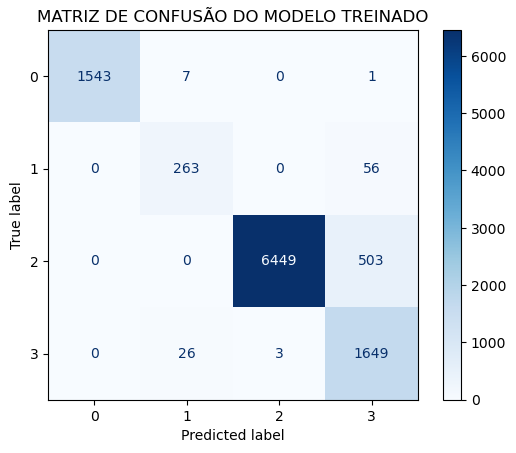

----------  SALVANDO MODELO DOIS  ----------


['modelo_dois.joblib']

In [12]:
##################################################################### 

## CRIANDO MODELO, TREINANDO E SALVANDO

#####################################################################

'''
ESTE QUADRO ALÉM DE CRIAR O MODELO, GARANTE A EXECUÇÃO DO PRESSUPOSTO:

1-DIVISÃO DA BASE TREINO E TESTE.
2-VALIDAÇÃO CRUZADA
3-MATRIZ DE CONFUSÃO
4-CURVA ROC  (é o último bloco de códigos)

PARA INTERPRETAR O RELATÓRIO DE CLASSIFICAÇÃO DO SKLEARN:

    PRECISION - A precisão mede a proporção de instâncias classificadas como 
    positivas e que realmente pertencem àquela classe, ou seja, de todos os exemplos que o modelo previu como sendo 
    da classe X, qual porcentagem era realmente da classe X? (falsos positivos) sendo assim sempre que ele preve
    aquela quantidade para a classe X ele acerta tantos %.

    RECALL (SENSIBILIDADE) - O recall mede a proporção de instâncias pertencentes a uma 
    classe que foram corretamente identificadas pelo modelo, ou seja, de todos os exemplos que realmente pertenciam à 
    classe X, qual porcentagem foi corretamente identificada? (falsos negativos) sendo assim sempre que ele preve
    aquela quantidade para a classe X ele erra tantos %.

    F1-SCORE - É a média harmônica entre precisão e recall, ou seja, representa um equilíbrio entre 
    a precisão e a sensibilidade. Ele é especialmente útil quando há um desbalanceamento entre classes.

    SUPPORT - Retorna o número de instâncias em cada uma das classes, apenas as instâncias originais do dataset, ou seja,
    se eu tenho 100 instâncias na classe X, o valor de support será 100.
    
    MACRO AVG - Média simples das métricas Precision, Recall e F1
    WEIGHTED AVG - Média ponderada das métricas Precision, Recall e F1
    
    N-ESTIMATORS é a quantidade de arvores, MAX_DEPTH é a profundidade da árvore e 
    RANDOM_SATE está garantindo a reprodução do modelo.
'''


########## GARANTINDO REPRODUÇÃO DO MODELO
semente = 45
np.random.seed(semente)


########## CRIANDO A BASE DO ML, A VARIAVEL PREDITA SERÁ O STATUS, ELA É MULTICLASSE (0,1,2,3)
base_principal = base_zero[['MES', 'ANO', 'SKU','CENTRO', 'QTD_ESTOQUE_LLPP', 'QTD_VENDAS', 'GIRO_LLPP',
                            'COBERTURA_LLPP', 'SAZONALIDADE', 'ESTOQUE_MINIMO_LLPP', 'ESTOQUE_IDEAL', 
                            'STATUS', 'NECESSIDADE']]



########## TRATANDO VALORES INFINITOS
base_principal.replace([np.inf, -np.inf], 0, inplace=True)


##SEPARANDO A VARIAVEL TARGET
x = base_principal.drop(columns=['STATUS'])
y = base_principal['STATUS']


########## SEPARANDO OS DADOS ENTRE TREINO E TESTE
#ATENDIMENTO DO PRESSUPOSTO 1
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)


########## CRIANDO O MODELO COM 10 ARVORES, MAXIMO DE 5 FOLHAS e TREINANDO O MODELO
modelo = RandomForestClassifier(n_estimators = 10, max_depth=3, random_state=2, class_weight='balanced')
modelo.fit(x_train, y_train)


########## CROSS VALIDATION 
#ATENDIMENTO DO PRESSUPOSTO 2
kf = KFold(n_splits=5, shuffle = True, random_state=2)
ml_data = cross_val_score(modelo, x, y, cv=kf, scoring = 'accuracy')



########## RESULTADOS VALIDAÇÃO CRUZADA
print('----------  RESULTADOS VALIDAÇÃO CRUZADA  ----------')
print(f"O tipo do modelo carregado é: {type(modelo)}")
print(f"Acurácias para cada fold (cross-validation): {ml_data}")
print(f"Acurácia média (cross-validation): {ml_data.mean()*100}")
print(f"Desvio padrão das acurácias (cross validation): {ml_data.std()}")


########## FAZENDO AS PREVISÕES NO CONJUNTO DE TESTE
predicao = modelo.predict(x_test)


########## FAZENDO AS PREVISÕES NO CONJUNTO DE TESTE e OBTENDO OS RESULTADOS
predicao = modelo.predict(x_test)
acuracia_base_teste = accuracy_score(y_test, predicao)

predicao_treino = modelo.predict(x_train)
acuracia_base_treino = accuracy_score(y_train, predicao_treino)

classificacao_base_teste = classification_report(y_test, predicao)
y_score = modelo.predict_proba(x_test) #aqui fala o quanto cada classe tem chance de ser, o % dessa chance



print('----------  RESULTADOS DA PREDIÇÃO NOS COJUNTOS TREINO E TESTE ----------')
print(f"Acurácia no treinamento: {acuracia_base_treino * 100:.2f}%")
print(f"Acurácia no conjunto de teste: {acuracia_base_teste * 100:.2f}%")
print('-------------------------')
print("Resultados do cojunto de teste (Precision, Recall e F1):")
print(classificacao_base_teste)
print('-------------------------')


########## CRIANDO A MATRIZ DE CONFUSAO
matriz_confusao_modelo_treinado = confusion_matrix(y_test, predicao, labels=np.unique(y_test))

########## MOSTRANDO A MATRIZ DE CONFUSAO
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao_modelo_treinado, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues)
plt.title('MATRIZ DE CONFUSÃO DO MODELO TREINADO')
plt.show()


########## SALVANDO MODELO PARA USAR NO CENÁRIO 2
from joblib import dump

print('----------  SALVANDO MODELO DOIS  ----------')
dump(modelo,'modelo_dois.joblib')
     

## AS ACURACIAS FICARAM BOAS AQUI, DESVIO PADRÃO E MÉDIA TAMBÉM. O MODELO APRESENTA 
## SINTOMAS DE OVERFITTING

----------------- PRINCIPAIS DADOS ESTATISITICOS DA BASE PRINCIPAL -----------------------------
           MES      ANO      SKU  QTD_ESTOQUE_LLPP  QTD_VENDAS  GIRO_LLPP  \
count 35000.00 35000.00 35000.00          35000.00    35000.00   35000.00   
mean      6.01  2020.47  9248.32             63.55      134.46       5.73   
std       3.16     1.70  1641.69             36.32       77.95      16.66   
min       1.00  2018.00   949.00              1.00        0.00       0.00   
25%       3.00  2019.00  9511.00             32.00       67.00       1.06   
50%       6.00  2020.00  9591.00             63.00      134.00       2.11   
75%       9.00  2022.00  9661.00             95.00      202.00       4.19   
max      11.00  2023.00  9721.00            126.00      269.00     268.00   

       COBERTURA_LLPP  SAZONALIDADE  ESTOQUE_MINIMO_LLPP  ESTOQUE_IDEAL  \
count        35000.00      35000.00             35000.00       35000.00   
mean            43.51          0.14                 5.27   

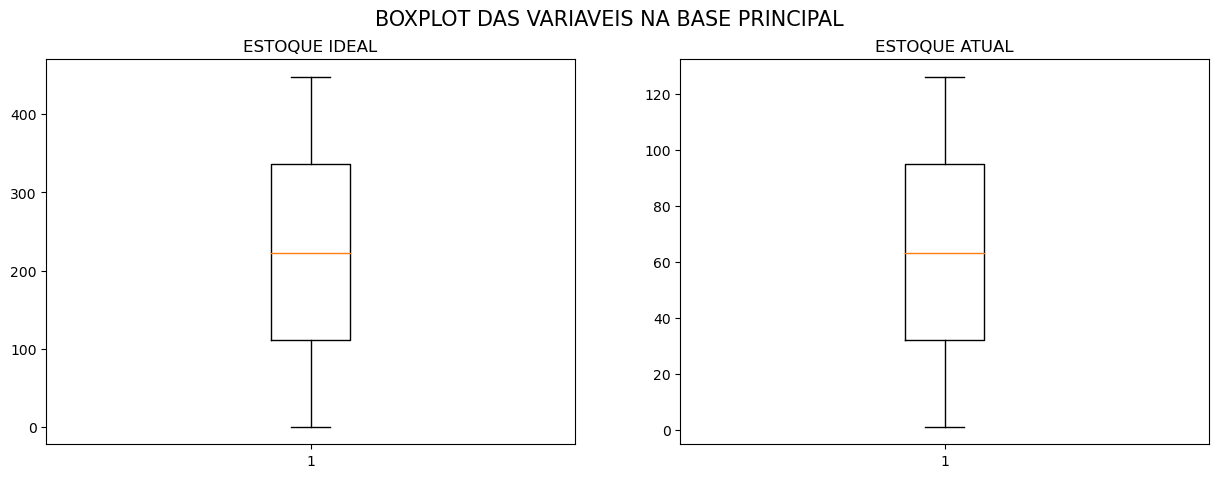

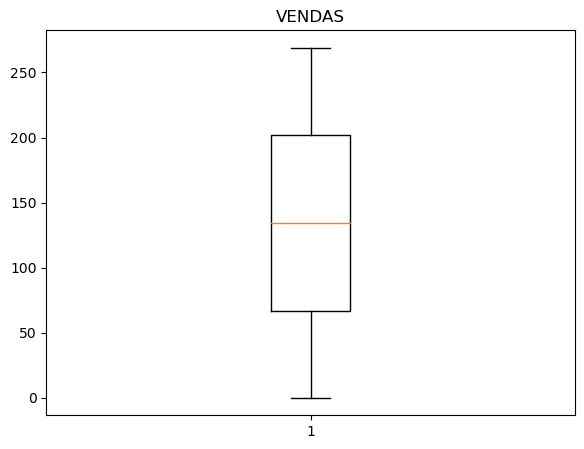

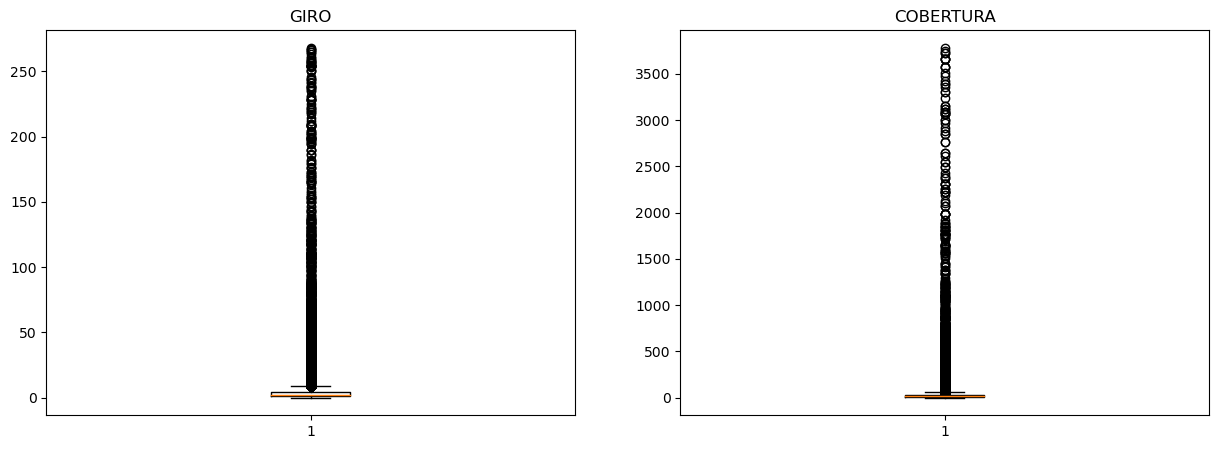

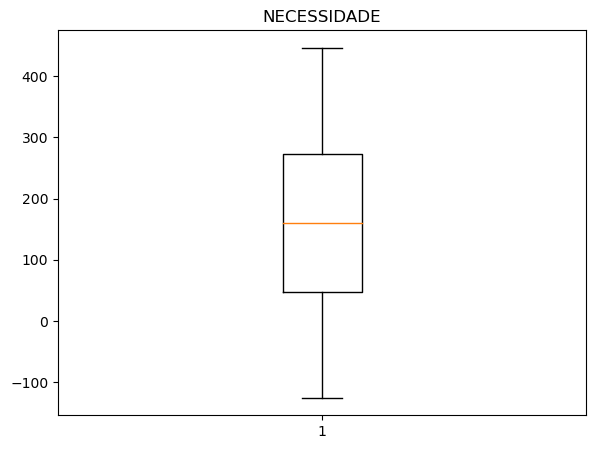

In [3]:
#######################  ANALISANDO A BASE DE DADOS ORIGINAL

print("----------------- PRINCIPAIS DADOS ESTATISITICOS DA BASE PRINCIPAL -----------------------------")
print(base_principal.describe())


print("----------------- BOXPLOT DOS DADOS BASE PRINCIPAL -----------------------------")

figura = plt.figure(figsize=(15,5))
figura.suptitle('BOXPLOT DAS VARIAVEIS NA BASE PRINCIPAL', fontsize=(15))


figura.add_subplot(121)
plt.boxplot(base_principal['ESTOQUE_IDEAL'], showfliers=True)
plt.title('ESTOQUE IDEAL')

figura.add_subplot(122)
plt.boxplot(base_principal['QTD_ESTOQUE_LLPP'], showfliers=True)
plt.title('ESTOQUE ATUAL')


figura2 = plt.figure(figsize=(15,5))
figura2.add_subplot(121)
plt.boxplot(base_principal['QTD_VENDAS'], showfliers=True)
plt.title('VENDAS')



figura3 = plt.figure(figsize=(15,5))
figura3.add_subplot(121)
plt.boxplot(base_principal['GIRO_LLPP'], showfliers=True)
plt.title('GIRO')

figura3.add_subplot(122)
plt.boxplot(base_principal['COBERTURA_LLPP'], showfliers=True)
plt.title('COBERTURA')


figura4 = plt.figure(figsize=(15,5))
figura4.add_subplot(121)
plt.boxplot(base_principal['NECESSIDADE'], showfliers=True)
plt.title('NECESSIDADE')



plt.show()

----------------- VISUALIZANDO AS DISTRIBUIÇÕES DA BASE PRINCIPAL-----------------------------


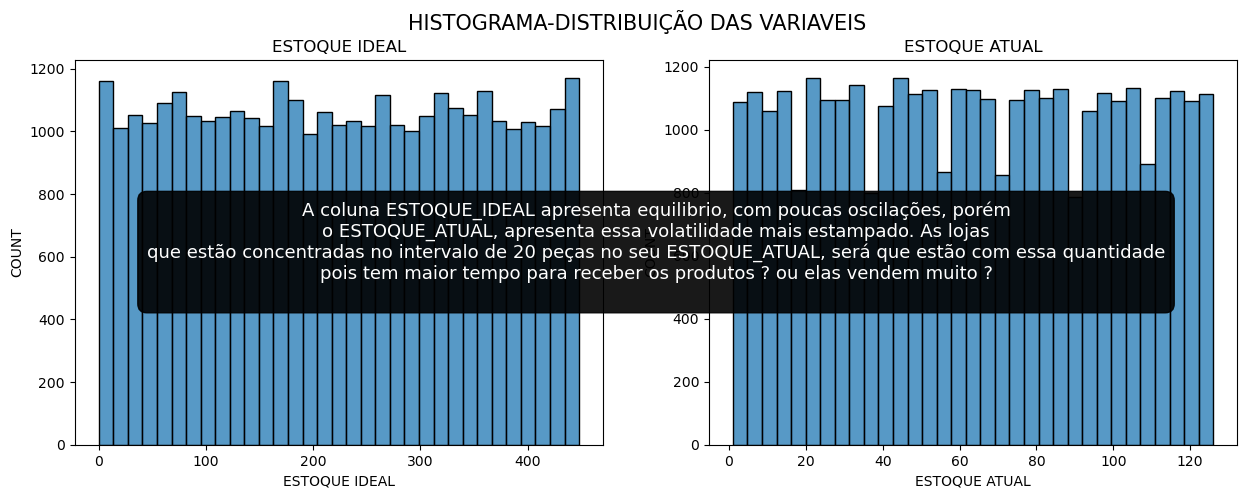

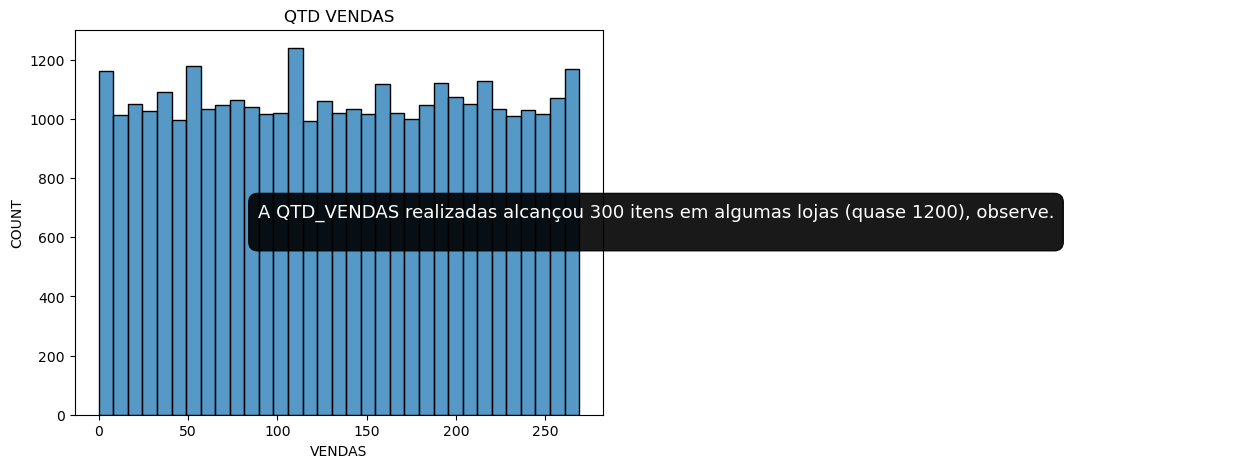

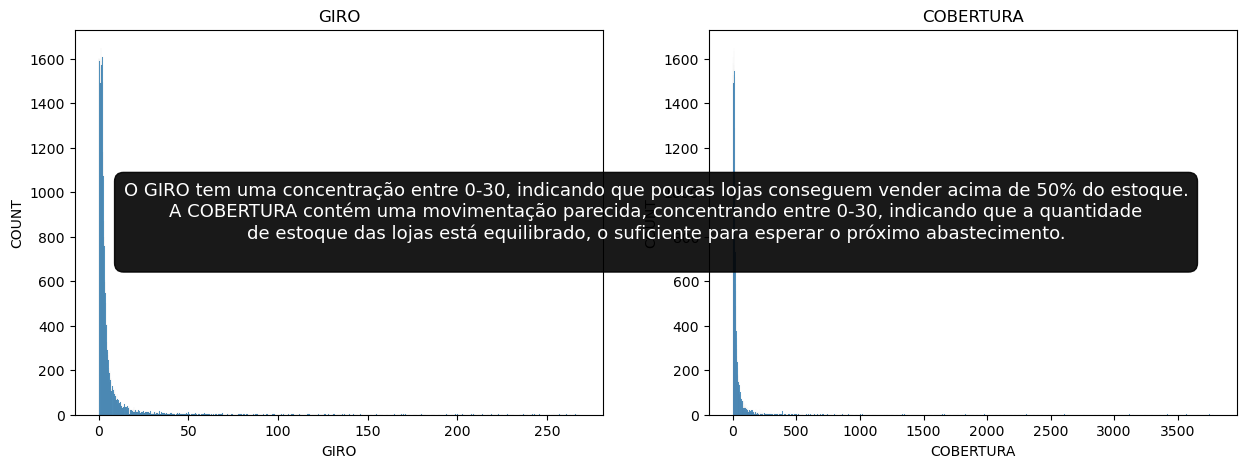

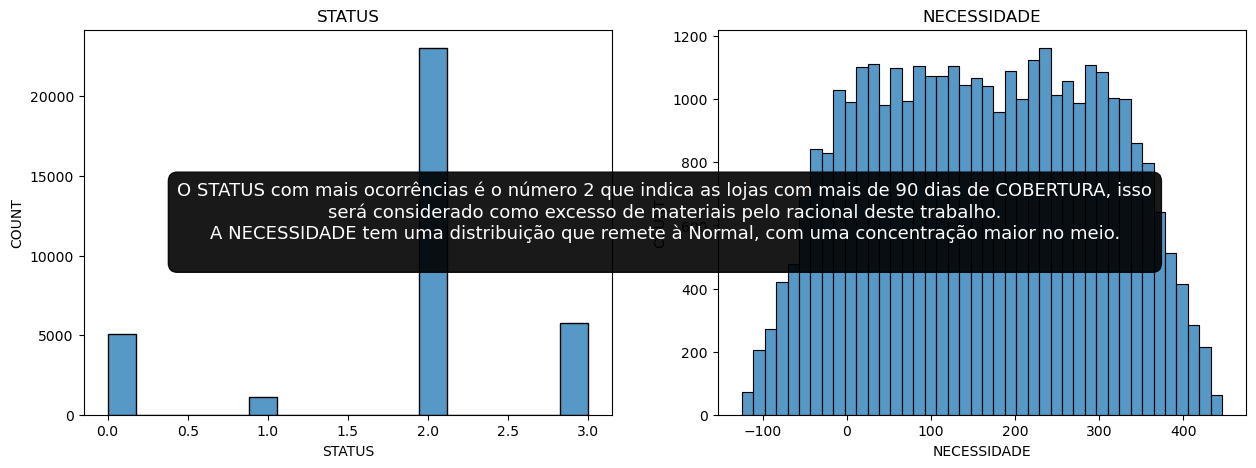

In [4]:

print("----------------- VISUALIZANDO AS DISTRIBUIÇÕES DA BASE PRINCIPAL-----------------------------")

###############  PLOTANDO AS DISTRIBUIÇÕES
figura = plt.figure(figsize=(15,5))
figura.suptitle('HISTOGRAMA-DISTRIBUIÇÃO DAS VARIAVEIS', fontsize=(15))

figura.add_subplot(121)
sns.histplot(base_principal['ESTOQUE_IDEAL'])
plt.title('ESTOQUE IDEAL')
plt.xlabel('ESTOQUE IDEAL')
plt.ylabel('COUNT')

figura.add_subplot(122)
sns.histplot(base_principal['QTD_ESTOQUE_LLPP'])
plt.title('ESTOQUE ATUAL')
plt.xlabel('ESTOQUE ATUAL')
plt.ylabel('COUNT')

descrito = figura.add_subplot(111)
descrito.axis('off')

tx= '''A coluna ESTOQUE_IDEAL apresenta equilibrio, com poucas oscilações, porém
o ESTOQUE_ATUAL, apresenta essa volatilidade mais estampado. As lojas
que estão concentradas no intervalo de 20 peças no seu ESTOQUE_ATUAL, será que estão com essa quantidade
pois tem maior tempo para receber os produtos ? ou elas vendem muito ?
'''
descrito.text(0.5, 0.5, tx, ha='center', va='center', fontsize=13, 
         color='white', bbox=dict(facecolor='black', alpha=0.9, boxstyle='round,pad=0.5'))

#
figura2 = plt.figure(figsize=(15,5))
figura2.add_subplot(121)
sns.histplot(base_principal['QTD_VENDAS'])
plt.title('QTD VENDAS')
plt.xlabel('VENDAS')
plt.ylabel('COUNT')


d1 = figura2.add_subplot(111)
d1.axis('off')

tx1= '''A QTD_VENDAS realizadas alcançou 300 itens em algumas lojas (quase 1200), observe.
'''
d1.text(0.5, 0.5, tx1, ha='center', va='center', fontsize=13, 
         color='white', bbox=dict(facecolor='black', alpha=0.9, boxstyle='round,pad=0.5'))

#
figura3 = plt.figure(figsize=(15,5))
figura3.add_subplot(121)
sns.histplot(base_principal['GIRO_LLPP'])
plt.title('GIRO')
plt.xlabel('GIRO')
plt.ylabel('COUNT')

figura3.add_subplot(122)
sns.histplot(base_principal['COBERTURA_LLPP'])
plt.title('COBERTURA')
plt.xlabel('COBERTURA')
plt.ylabel('COUNT')

d2 = figura3.add_subplot(111)
d2.axis('off')

tx2= '''O GIRO tem uma concentração entre 0-30, indicando que poucas lojas conseguem vender acima de 50% do estoque.
A COBERTURA contém uma movimentação parecida, concentrando entre 0-30, indicando que a quantidade
de estoque das lojas está equilibrado, o suficiente para esperar o próximo abastecimento.
'''
d2.text(0.5, 0.5, tx2, ha='center', va='center', fontsize=13, 
         color='white', bbox=dict(facecolor='black', alpha=0.9, boxstyle='round,pad=0.5'))


#
figura4 = plt.figure(figsize=(15,5))
figura4.add_subplot(121)
sns.histplot(base_principal['STATUS'])
plt.title('STATUS')
plt.xlabel('STATUS')
plt.ylabel('COUNT')

figura4.add_subplot(122)
sns.histplot(base_principal['NECESSIDADE'])
plt.title('NECESSIDADE')
plt.xlabel('NECESSIDADE')
plt.ylabel('COUNT')

d3 = figura4.add_subplot(111)
d3.axis('off')

tx3= '''O STATUS com mais ocorrências é o número 2 que indica as lojas com mais de 90 dias de COBERTURA, isso
será considerado como excesso de materiais pelo racional deste trabalho.
A NECESSIDADE tem uma distribuição que remete à Normal, com uma concentração maior no meio.
'''
d3.text(0.5, 0.5, tx3, ha='center', va='center', fontsize=13, 
         color='white', bbox=dict(facecolor='black', alpha=0.9, boxstyle='round,pad=0.5'))



plt.show()

C:\Users\Guilh\AppData\Local\Temp\ipykernel_11880\1593658228.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_um['ANO'] = 2025
C:\Users\Guilh\AppData\Local\Temp\ipykernel_11880\1593658228.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_um['QTD_VENDAS'] = np.where((base_um['MES'].isin([1,2,5,6,8,10,11,12])) &
C:\Users\Guilh\AppData\Local\Temp\ipykernel_11880\1593658228.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

----------------- DADOS ESTATISITICOS DA BASE CENARIO 1 -----------------------------
          MES     ANO     SKU  QTD_ESTOQUE_LLPP  QTD_VENDAS  GIRO_LLPP  \
count 5830.00 5830.00 5830.00           5830.00     5830.00    5830.00   
mean     6.01 2025.00 9249.58             63.24      132.14       5.74   
std      3.15    0.00 1638.65             36.39       76.62      16.53   
min      1.00 2025.00  949.00              1.00        0.00       0.00   
25%      3.00 2025.00 9511.00             32.00       67.00       1.06   
50%      6.00 2025.00 9591.00             63.00      132.00       2.09   
75%      9.00 2025.00 9661.00             95.00      196.00       4.15   
max     11.00 2025.00 9721.00            126.00      269.00     265.00   

       COBERTURA_LLPP  SAZONALIDADE  ESTOQUE_MINIMO_LLPP  ESTOQUE_IDEAL  \
count         5830.00       5830.00              5830.00        5830.00   
mean            44.49          0.14                 5.27         222.80   
std            176.92 

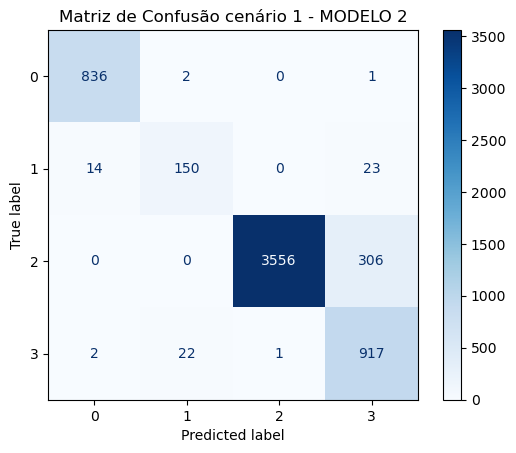

In [5]:
#################################################################################

## GERANDO A BASE DO CENARIO 1, QTD_VENDAS PARA ALGUNS PRODUTOS SERÁ AFETADO
## AS VENDAS DESTES PRODUTOS SERAO 15% MENORES EM MESES/ANOS SAZONAIS

#################################################################################



# GARANTINDO REPRODUÇÃO DO MODELO
semente = 45
#np.random.default_rng(semente)
np.random.seed(semente)


pd.set_option('Float_format','{:.2f}'.format)

########## BASE CENARIO 1
base_um = base_zero[base_zero['ANO']==2022]
base_um['ANO'] = 2025
base_um['QTD_VENDAS'] = np.where((base_um['MES'].isin([1,2,5,6,8,10,11,12])) & 
                                 (base_um['SKU'].isin([9511,9471,9611,9681])), 
                                  base_um['QTD_VENDAS']-(base_um['QTD_VENDAS']*0.15), base_um['QTD_VENDAS'])

########## SUBSTITUINDO NA POR 0
base_um['QTD_VENDAS'].fillna(0, inplace=True)


########## VERIFICANDO VAZIOS
linhas_nan = base_um[base_um.isna().any(axis=1)]
linhas_nan.head(10)


########## SELECIONANDO DATAFRAME
base_um = base_um[['MES', 'ANO', 'SKU','CENTRO', 'QTD_ESTOQUE_LLPP', 'QTD_VENDAS', 'GIRO_LLPP',
                            'COBERTURA_LLPP', 'SAZONALIDADE', 'ESTOQUE_MINIMO_LLPP', 'ESTOQUE_IDEAL', 
                            'NECESSIDADE', 'STATUS']]



########## CRIANDO COLUNAS CALCULADAS
base_um['GIRO_LLPP'] = ((base_um['QTD_VENDAS'])/base_um['QTD_ESTOQUE_LLPP'])
base_um['COBERTURA_LLPP'] = ((base_um['QTD_ESTOQUE_LLPP'])/base_um['QTD_VENDAS'])*30
base_um['NECESSIDADE'] = ((base_um['ESTOQUE_IDEAL'])-(base_um['QTD_ESTOQUE_LLPP']))
base_um.loc[base_um['NECESSIDADE'] < 16, 'STATUS'] = 1
base_um.loc[base_um['NECESSIDADE'] <= 0.0, 'STATUS'] = 0
base_um.loc[base_um['NECESSIDADE'] >= 90, 'STATUS'] = 2
base_um['STATUS'].fillna(3, inplace=True)
base_um['STATUS'] = base_um['STATUS'].astype(int)


########## CRIANDO COLUNAS COM CONDIÇÕES
base_um.loc[base_um['QTD_ESTOQUE_LLPP'] == 0, 'COBERTURA_LLPP'] = 0
base_um.loc[base_um['QTD_VENDAS'] == 0, 'GIRO_LLPP'] = 0


########## TRANSFORMANDO OS VALORES INFINITOS
base_um.replace([np.inf, -np.inf], 0, inplace=True)
base_um = base_um.drop_duplicates()



########## INFORMAÇÕES 
#base_um.head(10)
print("----------------- DADOS ESTATISITICOS DA BASE CENARIO 1 -----------------------------")
print(base_um.describe())
#print("----------- VERIFICANDO INFINITOS BASE CENÁRIO 1 -----------------------------------------")
#print(base_um.isin([np.inf, -np.inf]).sum())
print("---------------- BASE CENÁRIO 1 ------------------------------------")
print(base_um.head(5))



##################################################################### 

## APLICANDO MODELO NO CENARIO DE VENDAS 1

#####################################################################


## CARREGANDO MODELO
from joblib import load
modelo = load('modelo_dois.joblib')

##CRIANDO A BASE DO ML UTILIZANDO O STATUS EM BINARIO
cenario_um_completo = base_um.drop(columns=['STATUS'])
cenario_um_target = base_um['STATUS'].values

#FAZENDO AS PREVISOES NO CONJUNTO DE TESTE
pred_cenario_um = modelo.predict(cenario_um_completo)
acuracia_cenario_um = accuracy_score(cenario_um_target, pred_cenario_um)

#RESULTADOS 
print("----------------- ACURACIAS DO MODELO NO CENÁRIO 1 -----------------------------------")
print(f"Acurácia no cenário 1: {acuracia_cenario_um*100:.2f}%")
print(f"Acurácias para cada fold: {acuracia_cenario_um}")
print(f"Acurácia média: {acuracia_cenario_um.mean()*100}")
print(f"Desvio padrão das acurácias (cross validation): {acuracia_cenario_um.std()}")
print("---------------------Relatório de Classificação------------------------------")
print(classification_report(cenario_um_target, pred_cenario_um))



print("--------------- MATRIZ DE CONFUSAO CENÁRIO 1 -------------------------------------")

##################################################################### 

## MATRIZ DE CONFUSAO CENARIO 1

#####################################################################

# CRIANDO A MATRIZ DE CONFUSAO
matriz_confusao = confusion_matrix(cenario_um_target, pred_cenario_um, labels=np.unique(cenario_um_target))

# MOSTRANDO A MATRIZ DE CONFUSAO
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=np.unique(cenario_um_target))
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão cenário 1 - MODELO 2')
plt.show()

----------------- VISUALIZANDO AS DISTRIBUIÇÕES DO CENÁRIO 1-----------------------------


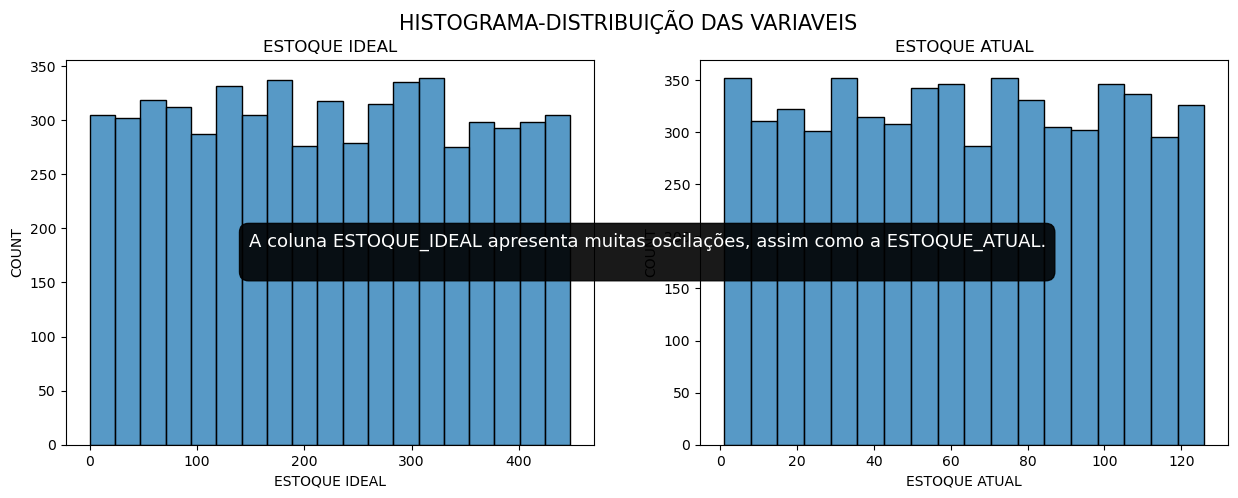

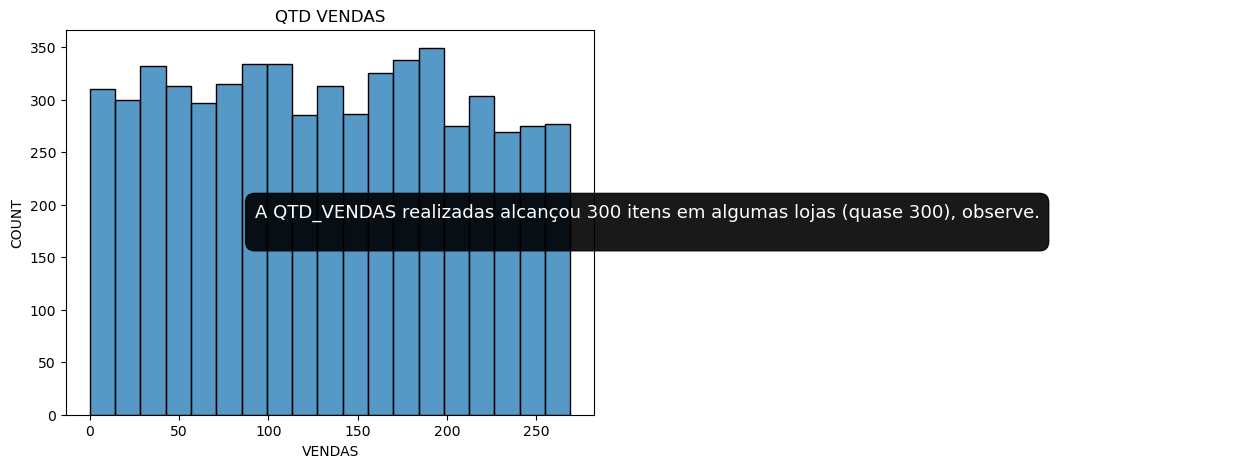

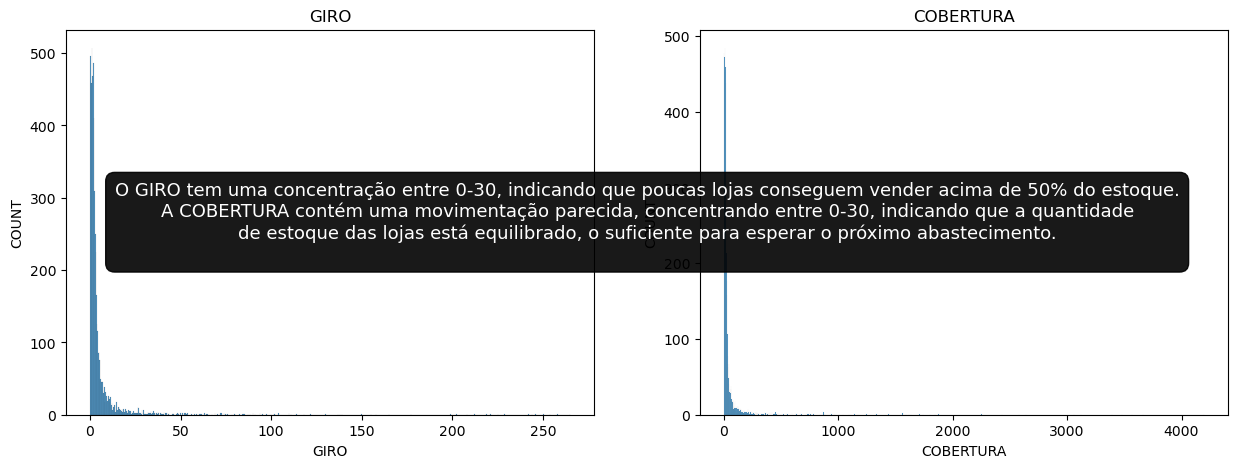

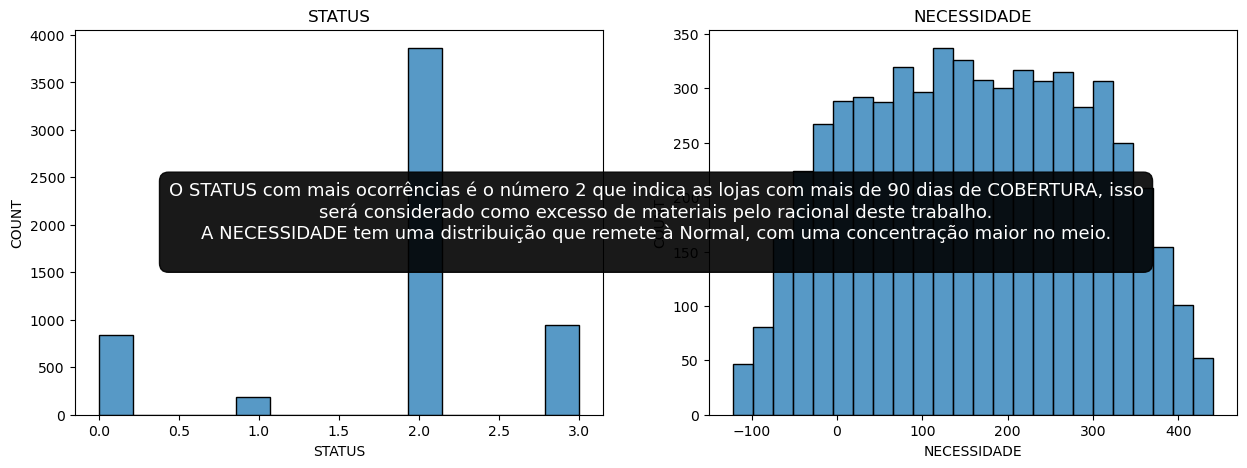

In [6]:

print("----------------- VISUALIZANDO AS DISTRIBUIÇÕES DO CENÁRIO 1-----------------------------")

###############  PLOTANDO AS DISTRIBUIÇÕES
figura = plt.figure(figsize=(15,5))
figura.suptitle('HISTOGRAMA-DISTRIBUIÇÃO DAS VARIAVEIS', fontsize=(15))

figura.add_subplot(121)
sns.histplot(base_um['ESTOQUE_IDEAL'])
plt.title('ESTOQUE IDEAL')
plt.xlabel('ESTOQUE IDEAL')
plt.ylabel('COUNT')

figura.add_subplot(122)
sns.histplot(base_um['QTD_ESTOQUE_LLPP'])
plt.title('ESTOQUE ATUAL')
plt.xlabel('ESTOQUE ATUAL')
plt.ylabel('COUNT')

descrito = figura.add_subplot(111)
descrito.axis('off')

tx= '''A coluna ESTOQUE_IDEAL apresenta muitas oscilações, assim como a ESTOQUE_ATUAL.
'''
descrito.text(0.5, 0.5, tx, ha='center', va='center', fontsize=13, 
         color='white', bbox=dict(facecolor='black', alpha=0.9, boxstyle='round,pad=0.5'))

#
figura2 = plt.figure(figsize=(15,5))
figura2.add_subplot(121)
sns.histplot(base_um['QTD_VENDAS'])
plt.title('QTD VENDAS')
plt.xlabel('VENDAS')
plt.ylabel('COUNT')


d1 = figura2.add_subplot(111)
d1.axis('off')

tx1= '''A QTD_VENDAS realizadas alcançou 300 itens em algumas lojas (quase 300), observe.
'''
d1.text(0.5, 0.5, tx1, ha='center', va='center', fontsize=13, 
         color='white', bbox=dict(facecolor='black', alpha=0.9, boxstyle='round,pad=0.5'))

#
figura3 = plt.figure(figsize=(15,5))
figura3.add_subplot(121)
sns.histplot(base_um['GIRO_LLPP'])
plt.title('GIRO')
plt.xlabel('GIRO')
plt.ylabel('COUNT')

figura3.add_subplot(122)
sns.histplot(base_um['COBERTURA_LLPP'])
plt.title('COBERTURA')
plt.xlabel('COBERTURA')
plt.ylabel('COUNT')

d2 = figura3.add_subplot(111)
d2.axis('off')

tx2= '''O GIRO tem uma concentração entre 0-30, indicando que poucas lojas conseguem vender acima de 50% do estoque.
A COBERTURA contém uma movimentação parecida, concentrando entre 0-30, indicando que a quantidade
de estoque das lojas está equilibrado, o suficiente para esperar o próximo abastecimento.
'''
d2.text(0.5, 0.5, tx2, ha='center', va='center', fontsize=13, 
         color='white', bbox=dict(facecolor='black', alpha=0.9, boxstyle='round,pad=0.5'))


#
figura4 = plt.figure(figsize=(15,5))
figura4.add_subplot(121)
sns.histplot(base_um['STATUS'])
plt.title('STATUS')
plt.xlabel('STATUS')
plt.ylabel('COUNT')

figura4.add_subplot(122)
sns.histplot(base_um['NECESSIDADE'])
plt.title('NECESSIDADE')
plt.xlabel('NECESSIDADE')
plt.ylabel('COUNT')

d3 = figura4.add_subplot(111)
d3.axis('off')

tx3= '''O STATUS com mais ocorrências é o número 2 que indica as lojas com mais de 90 dias de COBERTURA, isso
será considerado como excesso de materiais pelo racional deste trabalho.
A NECESSIDADE tem uma distribuição que remete à Normal, com uma concentração maior no meio.
'''
d3.text(0.5, 0.5, tx3, ha='center', va='center', fontsize=13, 
         color='white', bbox=dict(facecolor='black', alpha=0.9, boxstyle='round,pad=0.5'))



plt.show()

C:\Users\Guilh\AppData\Local\Temp\ipykernel_11880\3999858889.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_dois['ANO'] = 2025
C:\Users\Guilh\AppData\Local\Temp\ipykernel_11880\3999858889.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_dois['QTD_VENDAS']=np.where((base_dois['MES'].isin([1,2,5,6,8,10,11,12])) &
C:\Users\Guilh\AppData\Local\Temp\ipykernel_11880\3999858889.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in 

----------------- DADOS ESTATISITICOS DA BASE CENARIO 2 -----------------------------
          MES     ANO     SKU  QTD_ESTOQUE_LLPP  QTD_VENDAS  GIRO_LLPP  \
count 5830.00 5830.00 5830.00           5830.00     5830.00    5830.00   
mean     6.01 2025.00 9249.58             63.24      137.93       6.02   
std      3.15    0.00 1638.65             36.39       81.05      17.13   
min      1.00 2025.00  949.00              1.00        0.00       0.00   
25%      3.00 2025.00 9511.00             32.00       69.00       1.11   
50%      6.00 2025.00 9591.00             63.00      136.00       2.16   
75%      9.00 2025.00 9661.00             95.00      203.64       4.37   
max     11.00 2025.00 9721.00            126.00      360.45     265.00   

       COBERTURA_LLPP  SAZONALIDADE  ESTOQUE_MINIMO_LLPP  ESTOQUE_IDEAL  \
count         5830.00       5830.00              5830.00        5830.00   
mean            42.53          0.14                 5.27         222.80   
std            168.21 

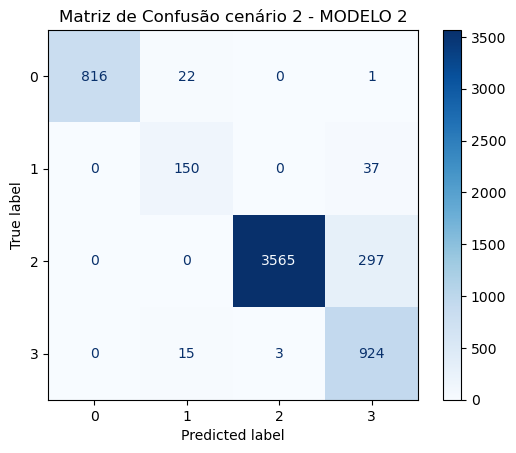

In [7]:
#################################################################################

## GERANDO A BASE DO CENARIO 2, QTD_VENDAS PARA ALGUNS PRODUTOS SERÁ AFETADO
## AS VENDAS DESTES PRODUTOS SERAO 35% MAIORES EM MESES/ANOS SAZONAIS

#################################################################################



# GARANTINDO REPRODUÇÃO DO MODELO
semente = 45
#np.random.default_rng(semente)
np.random.seed(semente)

pd.set_option('Float_format','{:.2f}'.format)



########## BASE CENARIO 2
base_dois = base_zero[base_zero['ANO']==2022]
base_dois['ANO'] = 2025
base_dois['QTD_VENDAS']=np.where((base_dois['MES'].isin([1,2,5,6,8,10,11,12])) & 
                                 (base_dois['SKU'].isin([9511,9471,9611,9681])), 
                                  base_dois['QTD_VENDAS']+(base_dois['QTD_VENDAS']*0.35), base_dois['QTD_VENDAS'])


########## SUBSTITUINDO NA POR 0
base_dois['QTD_VENDAS'].fillna(0, inplace=True)

########## VERIFICANDO VAZIOS
linhas_nan = base_dois[base_dois.isna().any(axis=1)]
linhas_nan.head(10)


########## SELECIONANDO DATAFRAME
base_dois = base_dois[['MES', 'ANO', 'SKU','CENTRO', 'QTD_ESTOQUE_LLPP', 'QTD_VENDAS', 'GIRO_LLPP',
                            'COBERTURA_LLPP', 'SAZONALIDADE', 'ESTOQUE_MINIMO_LLPP', 'ESTOQUE_IDEAL', 
                            'NECESSIDADE', 'STATUS']]



########## CRIANDO COLUNAS CALCULADAS
base_dois['GIRO_LLPP'] = ((base_dois['QTD_VENDAS'])/base_dois['QTD_ESTOQUE_LLPP'])
base_dois['COBERTURA_LLPP'] = ((base_dois['QTD_ESTOQUE_LLPP'])/base_dois['QTD_VENDAS'])*30
base_dois['NECESSIDADE'] = ((base_dois['ESTOQUE_IDEAL'])-(base_dois['QTD_ESTOQUE_LLPP']))
base_dois.loc[base_dois['NECESSIDADE'] < 16, 'STATUS'] = 1
base_dois.loc[base_dois['NECESSIDADE'] <= 0.0, 'STATUS'] = 0
base_dois.loc[base_dois['NECESSIDADE'] >= 90, 'STATUS'] = 2
base_dois['STATUS'].fillna(3, inplace=True)
base_dois['STATUS'] = base_dois['STATUS'].astype(int)


########## CRIANDO COLUNAS CONDIÇÕES, CASE WHEN
base_dois.loc[base_dois['QTD_ESTOQUE_LLPP'] == 0, 'COBERTURA_LLPP'] = 0
base_dois.loc[base_dois['QTD_VENDAS'] == 0, 'GIRO_LLPP'] = 0


########## TRANSFORMANDO OS VALORES INFINITOS
base_dois.replace([np.inf, -np.inf], 0, inplace=True)
base_dois = base_dois.drop_duplicates()


########## INFORMAÇÕES 
#base_um.head(10)
print("----------------- DADOS ESTATISITICOS DA BASE CENARIO 2 -----------------------------")
print(base_dois.describe())
#print("----------- VERIFICANDO INFINITOS BASE CENÁRIO 1 -----------------------------------------")
#print(base_dois.isin([np.inf, -np.inf]).sum())
print("---------------- BASE CENÁRIO 2 ------------------------------------")
print(base_dois.head(5))



##################################################################### 

## APLICANDO MODELO NO CENARIO DE VENDAS 2

#####################################################################


## CARREGANDO MODELO
from joblib import load
modelo = load('modelo_dois.joblib')

##CRIANDO A BASE DO ML UTILIZANDO O STATUS EM BINARIO
cenario_dois_completo = base_dois.drop(columns=['STATUS'])
cenario_dois_target = base_dois['STATUS'].values

#FAZENDO AS PREVISOES NO CONJUNTO DE TESTE
pred_cenario_dois = modelo.predict(cenario_dois_completo)
acuracia_cenario_dois = accuracy_score(cenario_dois_target, pred_cenario_dois)


#RESULTADOS 
print("----------------- ACURACIAS DO MODELO NO CENÁRIO 2 -----------------------------------")
print(f"Acurácia no cenário 2: {acuracia_cenario_dois*100:.2f}%")
print(f"Acurácias para cada fold: {acuracia_cenario_dois}")
print(f"Acurácia média: {acuracia_cenario_dois.mean()*100}")
print(f"Desvio padrão das acurácias (cross validation): {acuracia_cenario_dois.std()}")
print("---------------------Relatório de Classificação------------------------------")
print(classification_report(cenario_dois_target, pred_cenario_dois))



print("--------------- MATRIZ DE CONFUSAO CENÁRIO 2 -------------------------------------")

##################################################################### 

## MATRIZ DE CONFUSAO CENARIO 2

#####################################################################


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# CRIANDO A MATRIZ DE CONFUSAO
matriz_confusao = confusion_matrix(cenario_dois_target, pred_cenario_dois, labels=np.unique(cenario_dois_target))

# MOSTRANDO A MATRIZ DE CONFUSAO
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=np.unique(cenario_dois_target))
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão cenário 2 - MODELO 2')
plt.show()

----------------- VISUALIZANDO AS DISTRIBUIÇÕES DO CENÁRIO 2 -----------------------------


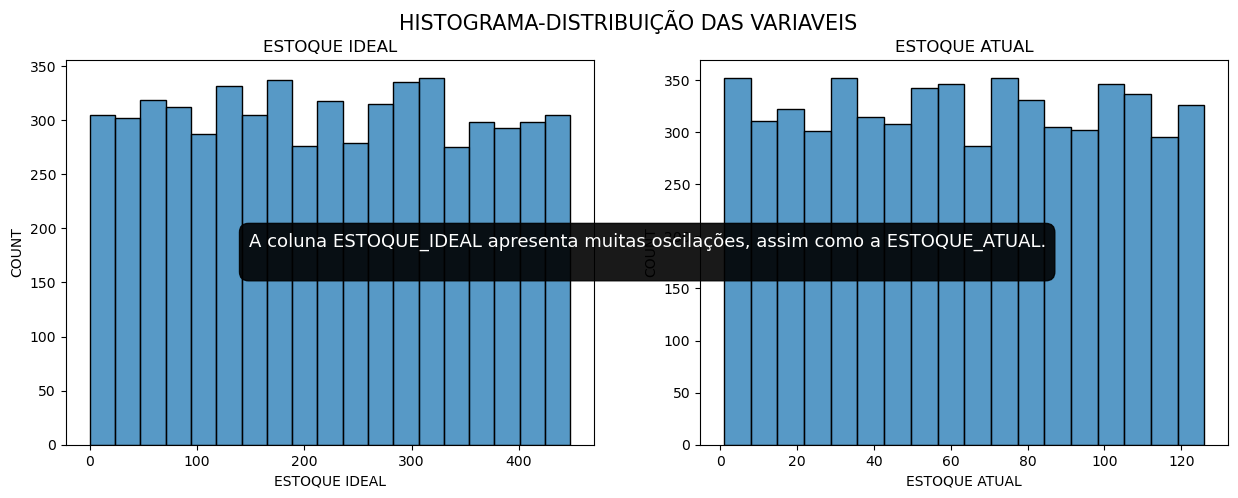

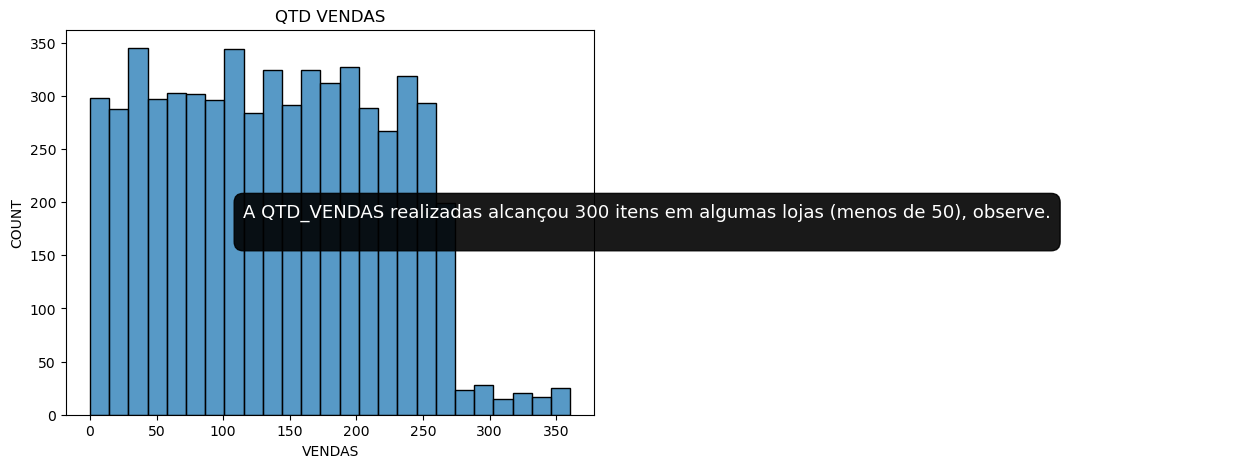

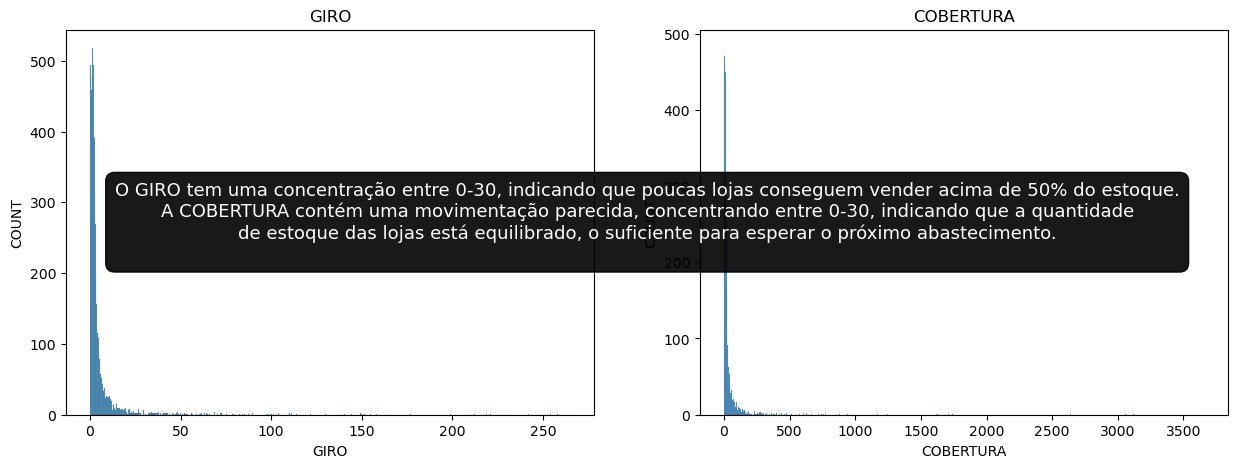

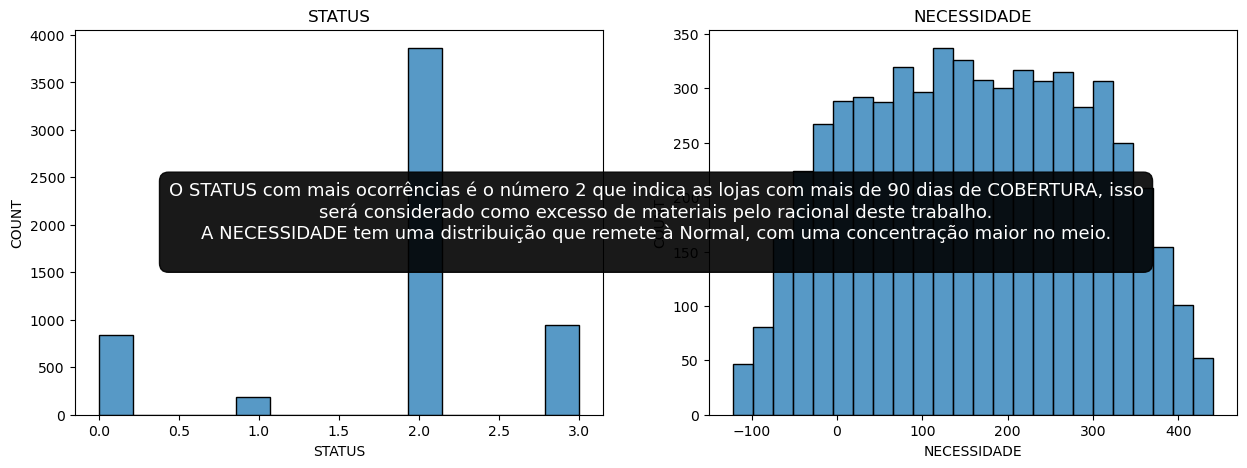

In [8]:

print("----------------- VISUALIZANDO AS DISTRIBUIÇÕES DO CENÁRIO 2 -----------------------------")

###############  PLOTANDO AS DISTRIBUIÇÕES
figura = plt.figure(figsize=(15,5))
figura.suptitle('HISTOGRAMA-DISTRIBUIÇÃO DAS VARIAVEIS', fontsize=(15))

figura.add_subplot(121)
sns.histplot(base_dois['ESTOQUE_IDEAL'])
plt.title('ESTOQUE IDEAL')
plt.xlabel('ESTOQUE IDEAL')
plt.ylabel('COUNT')

figura.add_subplot(122)
sns.histplot(base_dois['QTD_ESTOQUE_LLPP'])
plt.title('ESTOQUE ATUAL')
plt.xlabel('ESTOQUE ATUAL')
plt.ylabel('COUNT')

descrito = figura.add_subplot(111)
descrito.axis('off')

tx= '''A coluna ESTOQUE_IDEAL apresenta muitas oscilações, assim como a ESTOQUE_ATUAL.
'''
descrito.text(0.5, 0.5, tx, ha='center', va='center', fontsize=13, 
         color='white', bbox=dict(facecolor='black', alpha=0.9, boxstyle='round,pad=0.5'))

#
figura2 = plt.figure(figsize=(15,5))
figura2.add_subplot(121)
sns.histplot(base_dois['QTD_VENDAS'])
plt.title('QTD VENDAS')
plt.xlabel('VENDAS')
plt.ylabel('COUNT')


d1 = figura2.add_subplot(111)
d1.axis('off')

tx1= '''A QTD_VENDAS realizadas alcançou 300 itens em algumas lojas (menos de 50), observe.
'''
d1.text(0.5, 0.5, tx1, ha='center', va='center', fontsize=13, 
         color='white', bbox=dict(facecolor='black', alpha=0.9, boxstyle='round,pad=0.5'))

#
figura3 = plt.figure(figsize=(15,5))
figura3.add_subplot(121)
sns.histplot(base_dois['GIRO_LLPP'])
plt.title('GIRO')
plt.xlabel('GIRO')
plt.ylabel('COUNT')

figura3.add_subplot(122)
sns.histplot(base_dois['COBERTURA_LLPP'])
plt.title('COBERTURA')
plt.xlabel('COBERTURA')
plt.ylabel('COUNT')

d2 = figura3.add_subplot(111)
d2.axis('off')

tx2= '''O GIRO tem uma concentração entre 0-30, indicando que poucas lojas conseguem vender acima de 50% do estoque.
A COBERTURA contém uma movimentação parecida, concentrando entre 0-30, indicando que a quantidade
de estoque das lojas está equilibrado, o suficiente para esperar o próximo abastecimento.
'''
d2.text(0.5, 0.5, tx2, ha='center', va='center', fontsize=13, 
         color='white', bbox=dict(facecolor='black', alpha=0.9, boxstyle='round,pad=0.5'))


#
figura4 = plt.figure(figsize=(15,5))
figura4.add_subplot(121)
sns.histplot(base_dois['STATUS'])
plt.title('STATUS')
plt.xlabel('STATUS')
plt.ylabel('COUNT')

figura4.add_subplot(122)
sns.histplot(base_dois['NECESSIDADE'])
plt.title('NECESSIDADE')
plt.xlabel('NECESSIDADE')
plt.ylabel('COUNT')

d3 = figura4.add_subplot(111)
d3.axis('off')

tx3= '''O STATUS com mais ocorrências é o número 2 que indica as lojas com mais de 90 dias de COBERTURA, isso
será considerado como excesso de materiais pelo racional deste trabalho.
A NECESSIDADE tem uma distribuição que remete à Normal, com uma concentração maior no meio.
'''
d3.text(0.5, 0.5, tx3, ha='center', va='center', fontsize=13, 
         color='white', bbox=dict(facecolor='black', alpha=0.9, boxstyle='round,pad=0.5'))



plt.show()

C:\Users\Guilh\AppData\Local\Temp\ipykernel_11880\2351598176.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_tres['ANO'] = 2025
C:\Users\Guilh\AppData\Local\Temp\ipykernel_11880\2351598176.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_tres['QTD_VENDAS']=np.where((base_tres['MES'].isin([1,2,5,6,8,10,11,12])) &
C:\Users\Guilh\AppData\Local\Temp\ipykernel_11880\2351598176.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

----------------- DADOS ESTATISITICOS DA BASE CENARIO 3 -----------------------------
          MES     ANO     SKU  QTD_ESTOQUE_LLPP  QTD_VENDAS  GIRO_LLPP  \
count 5830.00 5830.00 5830.00           5830.00     5830.00    5830.00   
mean     6.01 2025.00 9249.58             63.24      139.05       6.04   
std      3.15    0.00 1638.65             36.39       82.76      17.04   
min      1.00 2025.00  949.00              1.00        0.00       0.00   
25%      3.00 2025.00 9511.00             32.00       70.00       1.12   
50%      6.00 2025.00 9591.00             63.00      137.00       2.18   
75%      9.00 2025.00 9661.00             95.00      204.00       4.37   
max     11.00 2025.00 9721.00            126.00      416.95     265.00   

       COBERTURA_LLPP  SAZONALIDADE  ESTOQUE_MINIMO_LLPP  ESTOQUE_IDEAL  \
count         5830.00       5830.00              5830.00        5830.00   
mean            42.52          0.14                 5.27         222.80   
std            168.68 

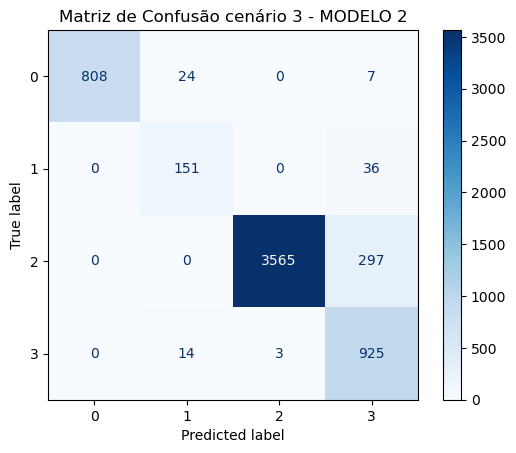

In [9]:
#################################################################################

## GERANDO A BASE DO CENARIO 3, QTD_VENDAS PARA ALGUNS PRODUTOS SERÁ AFETADO
## AS VENDAS DESTES PRODUTOS SERAO 10% MAIORES EM MESES SAZONAIS E 
## 55% MAIORES NOS OUTROS

#################################################################################

# GARANTINDO REPRODUÇÃO DO MODELO
semente = 45
#np.random.default_rng(semente)
np.random.seed(semente)

########## BASE CENARIO 3
base_tres = base_zero[base_zero['ANO']==2022]
base_tres['ANO'] = 2025
base_tres['QTD_VENDAS']=np.where((base_tres['MES'].isin([1,2,5,6,8,10,11,12])) & 
                                 (base_tres['SKU'].isin([9511,9471,9611,9681])), 
                                  base_tres['QTD_VENDAS']+(base_tres['QTD_VENDAS']*0.1), base_tres['QTD_VENDAS'])

base_tres['QTD_VENDAS']=np.where((base_tres['MES'].isin([3,4,7,9])) & 
                                 (base_tres['SKU'].isin([9511,9471,9611,9681])), 
                                  base_tres['QTD_VENDAS']+(base_tres['QTD_VENDAS']*0.55), base_tres['QTD_VENDAS'])


########## SUBSTITUINDO NA POR 0
base_tres['QTD_VENDAS'].fillna(0, inplace=True)

########## VERIFICANDO VAZIOS
linhas_nan = base_tres[base_tres.isna().any(axis=1)]
linhas_nan.head(10)


########## SELECIONANDO DATAFRAME
base_tres = base_tres[['MES', 'ANO', 'SKU','CENTRO', 'QTD_ESTOQUE_LLPP', 'QTD_VENDAS', 'GIRO_LLPP',
                            'COBERTURA_LLPP', 'SAZONALIDADE', 'ESTOQUE_MINIMO_LLPP', 'ESTOQUE_IDEAL', 
                            'NECESSIDADE', 'STATUS']]




########## CRIANDO COLUNAS CALCULADAS
base_tres['GIRO_LLPP'] = ((base_tres['QTD_VENDAS'])/base_tres['QTD_ESTOQUE_LLPP'])
base_tres['COBERTURA_LLPP'] = ((base_tres['QTD_ESTOQUE_LLPP'])/base_tres['QTD_VENDAS'])*30
base_tres['NECESSIDADE'] = ((base_tres['ESTOQUE_IDEAL'])-(base_tres['QTD_ESTOQUE_LLPP']))
base_tres.loc[base_tres['NECESSIDADE'] < 16, 'STATUS'] = 1
base_tres.loc[base_tres['NECESSIDADE'] <= 0.0, 'STATUS'] = 0
base_tres.loc[base_tres['NECESSIDADE'] >= 90, 'STATUS'] = 2
base_tres['STATUS'].fillna(3, inplace=True)
base_tres['STATUS'] = base_tres['STATUS'].astype(int)


########## CRIANDO COLUNAS CONDIÇÕES, CASE WHEN
base_tres.loc[base_tres['QTD_ESTOQUE_LLPP'] == 0, 'COBERTURA_LLPP'] = 0
base_tres.loc[base_tres['QTD_VENDAS'] == 0, 'GIRO_LLPP'] = 0


########## TRANSFORMANDO OS VALORES INFINITOS
base_tres.replace([np.inf, -np.inf], 0, inplace=True)
base_tres = base_tres.drop_duplicates()



########## INFORMAÇÕES 
#base_um.head(10)
print("----------------- DADOS ESTATISITICOS DA BASE CENARIO 3 -----------------------------")
print(base_tres.describe())
#print("----------- VERIFICANDO INFINITOS BASE CENÁRIO 1 -----------------------------------------")
#print(base_dois.isin([np.inf, -np.inf]).sum())
print("---------------- BASE CENÁRIO 3 ------------------------------------")
print(base_tres.head(5))



##################################################################### 

## APLICANDO MODELO NO CENARIO DE VENDAS 3

#####################################################################


## CARREGANDO MODELO
from joblib import load
modelo = load('modelo_dois.joblib')

##CRIANDO A BASE DO ML UTILIZANDO O STATUS EM BINARIO
cenario_tres_completo = base_tres.drop(columns=['STATUS'])
cenario_tres_target = base_tres['STATUS'].values

#FAZENDO AS PREVISOES NO CONJUNTO DE TESTE
pred_cenario_tres = modelo.predict(cenario_tres_completo)
acuracia_cenario_tres = accuracy_score(cenario_tres_target, pred_cenario_tres)


#RESULTADOS 
print("----------------- ACURACIAS DO MODELO NO CENÁRIO 3 -----------------------------------")
print(f"Acurácia no cenário 3: {acuracia_cenario_tres*100:.2f}%")
print(f"Acurácias para cada fold: {acuracia_cenario_tres}")
print(f"Acurácia média: {acuracia_cenario_tres.mean()*100}")
print(f"Desvio padrão das acurácias (cross validation): {acuracia_cenario_tres.std()}")
print("---------------------Relatório de Classificação------------------------------")
print(classification_report(cenario_tres_target, pred_cenario_tres))



print("--------------- MATRIZ DE CONFUSAO CENÁRIO 3 -------------------------------------")

##################################################################### 

## MATRIZ DE CONFUSAO CENARIO 3

#####################################################################


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# CRIANDO A MATRIZ DE CONFUSAO
matriz_confusao = confusion_matrix(cenario_tres_target, pred_cenario_tres, labels=np.unique(cenario_tres_target))

# MOSTRANDO A MATRIZ DE CONFUSAO
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=np.unique(cenario_tres_target))
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão cenário 3 - MODELO 2')
plt.show()

----------------- VISUALIZANDO AS DISTRIBUIÇÕES DO CENARIO 3-----------------------------


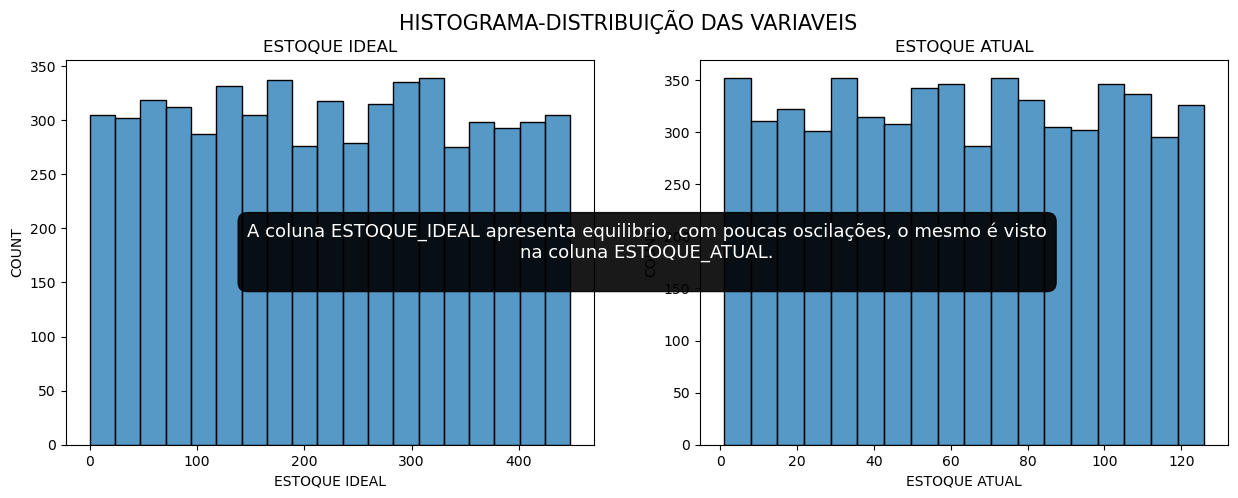

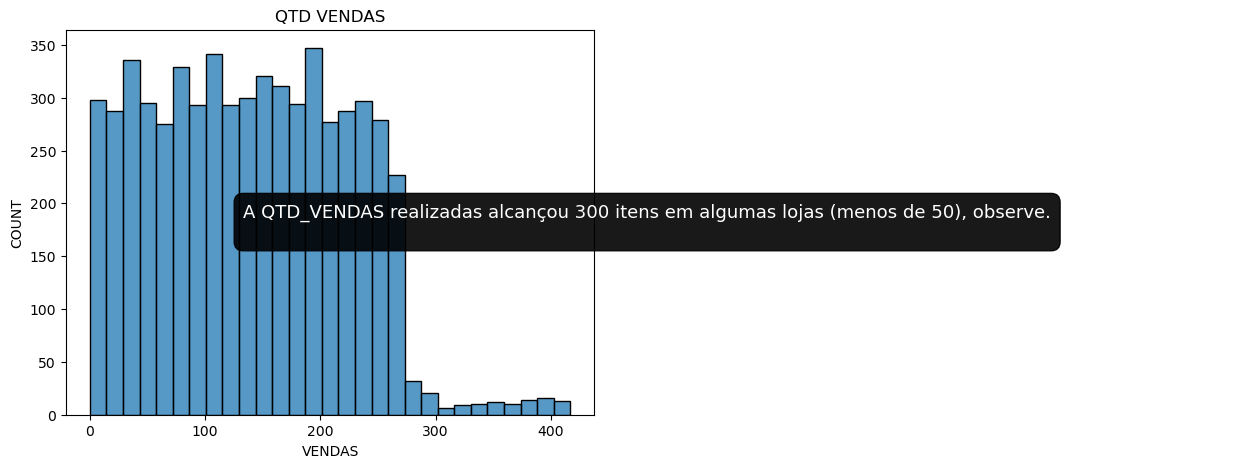

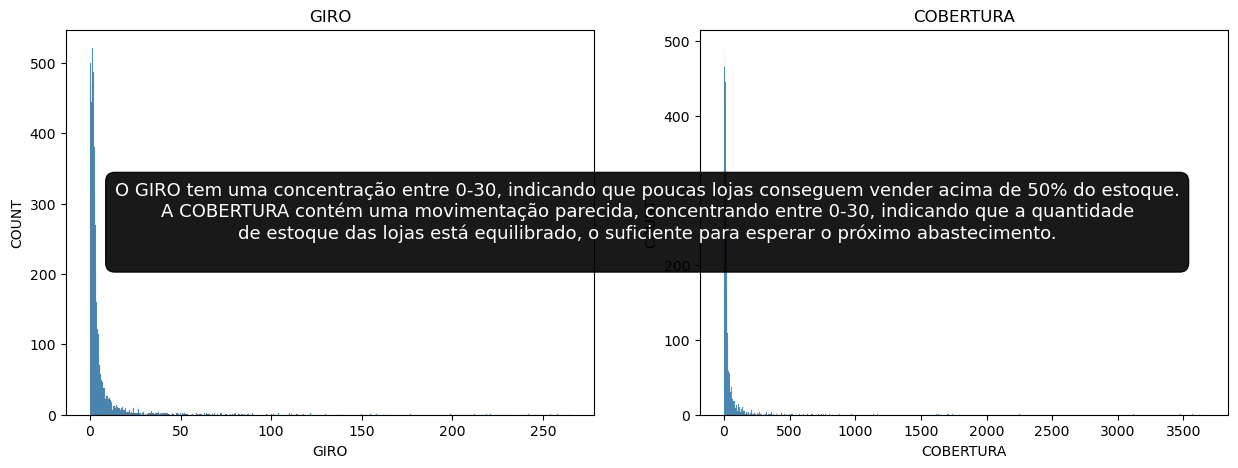

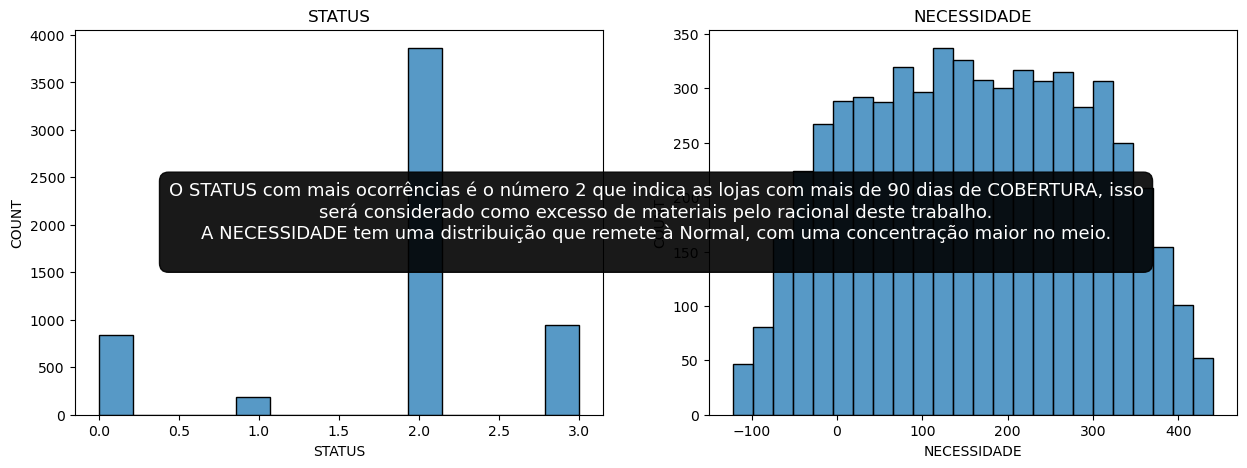

In [10]:
print("----------------- VISUALIZANDO AS DISTRIBUIÇÕES DO CENARIO 3-----------------------------")

###############  PLOTANDO AS DISTRIBUIÇÕES
figura = plt.figure(figsize=(15,5))
figura.suptitle('HISTOGRAMA-DISTRIBUIÇÃO DAS VARIAVEIS', fontsize=(15))

figura.add_subplot(121)
sns.histplot(base_tres['ESTOQUE_IDEAL'])
plt.title('ESTOQUE IDEAL')
plt.xlabel('ESTOQUE IDEAL')
plt.ylabel('COUNT')

figura.add_subplot(122)
sns.histplot(base_tres['QTD_ESTOQUE_LLPP'])
plt.title('ESTOQUE ATUAL')
plt.xlabel('ESTOQUE ATUAL')
plt.ylabel('COUNT')

descrito = figura.add_subplot(111)
descrito.axis('off')

tx= '''A coluna ESTOQUE_IDEAL apresenta equilibrio, com poucas oscilações, o mesmo é visto
na coluna ESTOQUE_ATUAL.
'''
descrito.text(0.5, 0.5, tx, ha='center', va='center', fontsize=13, 
         color='white', bbox=dict(facecolor='black', alpha=0.9, boxstyle='round,pad=0.5'))

#
figura2 = plt.figure(figsize=(15,5))
figura2.add_subplot(121)
sns.histplot(base_tres['QTD_VENDAS'])
plt.title('QTD VENDAS')
plt.xlabel('VENDAS')
plt.ylabel('COUNT')


d1 = figura2.add_subplot(111)
d1.axis('off')

tx1= '''A QTD_VENDAS realizadas alcançou 300 itens em algumas lojas (menos de 50), observe.
'''
d1.text(0.5, 0.5, tx1, ha='center', va='center', fontsize=13, 
         color='white', bbox=dict(facecolor='black', alpha=0.9, boxstyle='round,pad=0.5'))

#
figura3 = plt.figure(figsize=(15,5))
figura3.add_subplot(121)
sns.histplot(base_tres['GIRO_LLPP'])
plt.title('GIRO')
plt.xlabel('GIRO')
plt.ylabel('COUNT')

figura3.add_subplot(122)
sns.histplot(base_tres['COBERTURA_LLPP'])
plt.title('COBERTURA')
plt.xlabel('COBERTURA')
plt.ylabel('COUNT')

d2 = figura3.add_subplot(111)
d2.axis('off')

tx2= '''O GIRO tem uma concentração entre 0-30, indicando que poucas lojas conseguem vender acima de 50% do estoque.
A COBERTURA contém uma movimentação parecida, concentrando entre 0-30, indicando que a quantidade
de estoque das lojas está equilibrado, o suficiente para esperar o próximo abastecimento.
'''
d2.text(0.5, 0.5, tx2, ha='center', va='center', fontsize=13, 
         color='white', bbox=dict(facecolor='black', alpha=0.9, boxstyle='round,pad=0.5'))


#
figura4 = plt.figure(figsize=(15,5))
figura4.add_subplot(121)
sns.histplot(base_tres['STATUS'])
plt.title('STATUS')
plt.xlabel('STATUS')
plt.ylabel('COUNT')

figura4.add_subplot(122)
sns.histplot(base_tres['NECESSIDADE'])
plt.title('NECESSIDADE')
plt.xlabel('NECESSIDADE')
plt.ylabel('COUNT')

d3 = figura4.add_subplot(111)
d3.axis('off')

tx3= '''O STATUS com mais ocorrências é o número 2 que indica as lojas com mais de 90 dias de COBERTURA, isso
será considerado como excesso de materiais pelo racional deste trabalho.
A NECESSIDADE tem uma distribuição que remete à Normal, com uma concentração maior no meio.
'''
d3.text(0.5, 0.5, tx3, ha='center', va='center', fontsize=13, 
         color='white', bbox=dict(facecolor='black', alpha=0.9, boxstyle='round,pad=0.5'))



plt.show()

In [11]:
'''
######################  PRESSUPOSTO DO RANDOM FOREST

------------Dados de entrada
Não requer normalização ou padronização, pois não é sensível à escala dos dados.
Suporta tanto dados categóricos (devidamente codificados) quanto numéricos.

------------Independência dos dados
As observações no dataset devem ser aproximadamente independentes e representativas da população de interesse.
Evite duplicação ou correlação extrema entre as amostras (dados desbalanceados podem exigir ajustes, como oversampling 
ou undersampling). 

------------Número suficiente de amostras e features
Precisa de um número adequado de amostras para obter boas estimativas, especialmente para problemas com muitas variáveis.

------------Ausência de multicolinearidade crítica
Embora o Random Forest lide bem com features correlacionadas, variáveis altamente redundantes podem impactar
a interpretabilidade.


######################  VALIDAÇÃO DO MODELO

A validação é essencial para garantir que o modelo RandomForestClassifier esteja generalizando bem para novos dados. Aqui estão os métodos principais:

1. Divisão treino-teste
Divida os dados em conjuntos de treino e teste, normalmente 70% para treino e 30% para teste, ou outra divisão semelhante.
Use o conjunto de teste para avaliar a performance em dados nunca vistos.

2. Validação cruzada (Cross-Validation)
Divida os dados em k partes (k-fold), onde k é frequentemente 5 ou 10.
Em cada iteração, um dos folds é usado como validação, enquanto os demais são usados como treino.
Avalie as métricas médias para obter uma performance mais estável e confiável.

3. Matriz de Confusão
Use uma matriz de confusão para avaliar como o modelo está performando para cada classe.
Métricas derivadas como precisão, revocação, F1-score e especificidade ajudam a identificar áreas de melhora.

4. Curva ROC e AUC (para problemas binários ou multilabel)
Avalie a capacidade do modelo de distinguir entre classes.
CURVA ROC para um modelo multiclasse (como o RandomForestClassifier), você pode usar a estratégia de "one-vs-rest" (OvR), 
que avalia cada classe contra todas as outras combinadas.

    Se a curva ROC ficar bem alta (próxima do canto superior esquerdo):
    Isso significa que seu modelo está excelente em detectar spams sem cometer muitos erros.
    
    Se a curva ROC for uma linha reta na diagonal (45°):
    O modelo está basicamente adivinhando aleatoriamente. É como jogar uma moeda.
    
    Área sob a curva (AUC):
    Uma medida do desempenho geral do modelo.
    AUC = 1.0: Perfeito.
    AUC = 0.5: Igual a adivinhar ao acaso.




5. Feature Importance
Analise a importância das features no modelo para garantir que as variáveis relevantes estejam contribuindo para o resultado.

6. Testes em novos dados
Avalie o modelo em um conjunto de dados não visto e independente do que foi usado na construção ou validação inicial.


######################  EXEMPLOS DE METRICAS
------------Para classificação binária ou multiclasse:

Acurácia: fração de predições corretas.
F1-Score: equilíbrio entre precisão e revocação, útil para dados desbalanceados.
Log-Loss: mede a incerteza nas previsões probabilísticas.
Precision (Precisão): proporção de verdadeiros positivos entre os exemplos classificados como positivos.
Recall (Revocação): proporção de verdadeiros positivos sobre todos os exemplos reais positivos.
'''

'\n######################  PRESSUPOSTO DO RANDOM FOREST\n\n------------Dados de entrada\nNão requer normalização ou padronização, pois não é sensível à escala dos dados.\nSuporta tanto dados categóricos (devidamente codificados) quanto numéricos.\n\n------------Independência dos dados\nAs observações no dataset devem ser aproximadamente independentes e representativas da população de interesse.\nEvite duplicação ou correlação extrema entre as amostras (dados desbalanceados podem exigir ajustes, como oversampling \nou undersampling). \n\n------------Número suficiente de amostras e features\nPrecisa de um número adequado de amostras para obter boas estimativas, especialmente para problemas com muitas variáveis.\n\n------------Ausência de multicolinearidade crítica\nEmbora o Random Forest lide bem com features correlacionadas, variáveis altamente redundantes podem impactar\na interpretabilidade.\n\n\n######################  VALIDAÇÃO DO MODELO\n\nA validação é essencial para garantir que 

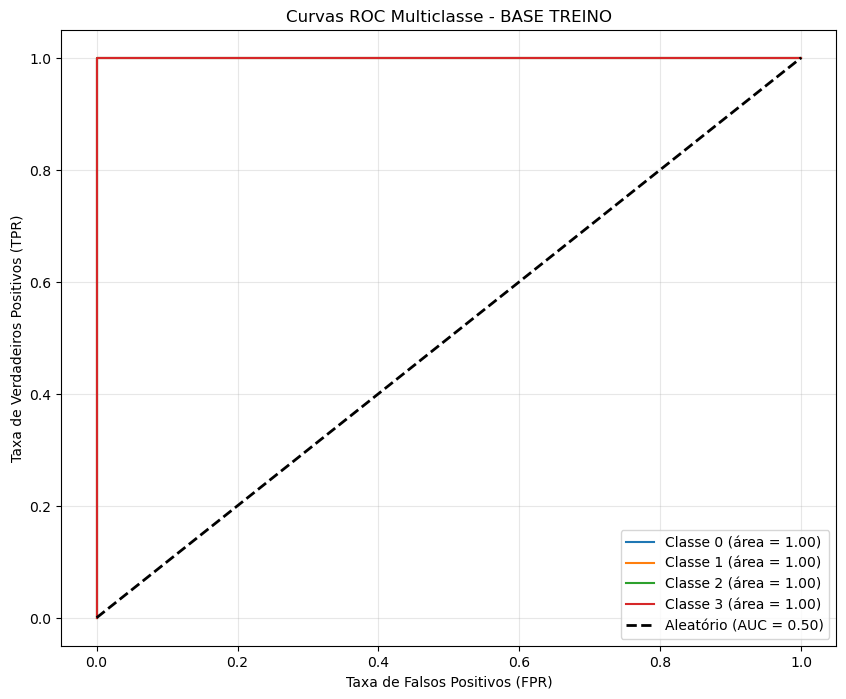

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


######################### PREPARANDO A BASE

# Exemplo de dados
#x = base_principal.drop(columns=['STATUS'])
#y = base_principal['STATUS']
x = base_principal.drop(columns=['STATUS'])
y = base_principal['STATUS'].values

# Dividir os dados
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Treine o modelo RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(x_train, y_train)


# Binarizar as classes
classes = [0, 1, 2, 3]
y_test_bin = label_binarize(y_test, classes=classes)  # rótulos binarizados
#n_classes = y_test_bin.shape[1]


######################### OBTENDO AS PROBABILIDADES

y_score = model.predict_proba(x_test)

######################### CALCULANDO A CURVA ROC
# Calculando as curvas ROC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotando as curvas ROC
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (área = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Aleatório (AUC = 0.50)')
plt.title('Curvas ROC Multiclasse - BASE TREINO')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()